In [0]:
!pip install shap

In [0]:
import shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Normalizer

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb

df = pd.read_csv('/content/Finalized data.csv', na_values=[-1])

prediction_targets = ['iv208rer', 'iv209rer', 'iv210rer', 'iv211rer','iv212rer', 'iv213rer']

features = ['parcntq','parinfq','edfa57q','edmo57q', 'sesp57','ocf57',
            'piearl','ocsf57','ocpf57', 'ocm157','ocsmo5','ocpmo5','bklvpr',
            'bkhs57','brdyhh', 'edhhyr','bkhhw5','cwhh57u',
            'inmh57u','ocmh57u','ocsh57u2','ocph57u2','oceh57','ocih57',
            'natfth','zparnf']

cat_features = [ 'ocf57','ocm157','bklvpr',
                'bkhs57','bkhhw5','cwhh57u', 'inmh57u','ocmh57u','natfth']

ord_features = ['parcntq','parinfq','sesp57','zparnf']

num_features = ['edfa57q','edmo57q','piearl','ocsf57','ocpf57','ocsmo5','ocpmo5','brdyhh','edhhyr','ocsh57u2','ocph57u2','oceh57','ocih57']

df = np.take(df, np.where((df.loc[:,prediction_targets] == -3).sum(axis=1) == 0)[0], axis=0)
df = np.take(df, np.where((df.loc[:,features] == -2).sum(axis=1) == 0)[0], axis=0)
df.loc[:, prediction_targets] = df.loc[:, prediction_targets].replace(1, 0)
df.loc[:, prediction_targets] = df.loc[:, prediction_targets].replace([2,3,4], 1)

###Visulization

In [0]:
def visulize(df, fea_name):
  #value count
  print(df[fea_name].value_counts())

  fig = plt.figure(figsize = (17,5))

  #histogrm plot
  ax = fig.add_subplot(1,3,1)
  df.loc[:,fea_name].hist(color='green',alpha=0.5,rwidth=0.8, density=True,
                          grid=False,ax=ax, bins=20)
  plt.axvline(df.loc[:,fea_name].mean(), 
              color='r',linestyle=':',label = 'mean')
  plt.axvline(df.loc[:,fea_name].median(), color='b', linestyle='-.', 
              label = 'median')
  plt.legend()
  #df.loc[:,fea_name].plot(kind='density', color='green')
  ax.set_title("Histogram of " + fea_name)

  #boxplot
  ax = fig.add_subplot(1,3,2)
  df.loc[:,[fea_name]].boxplot(grid=False,ax=ax)
  ax.set_title("Boxplot of " + fea_name)

  #barplot
  ax = fig.add_subplot(1,3,3)
  df.loc[:,[fea_name]].mean().plot.bar(yerr=df[fea_name].std(),rot=0)
  ax.set_title("Barplot of " + fea_name)
  plt.show()

0.0    4417
1.0    1440
Name: iv208rer, dtype: int64


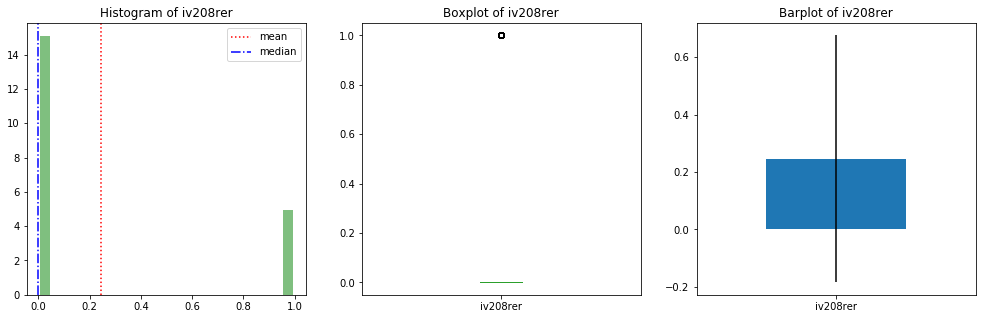

0.0    4589
1.0    1268
Name: iv209rer, dtype: int64


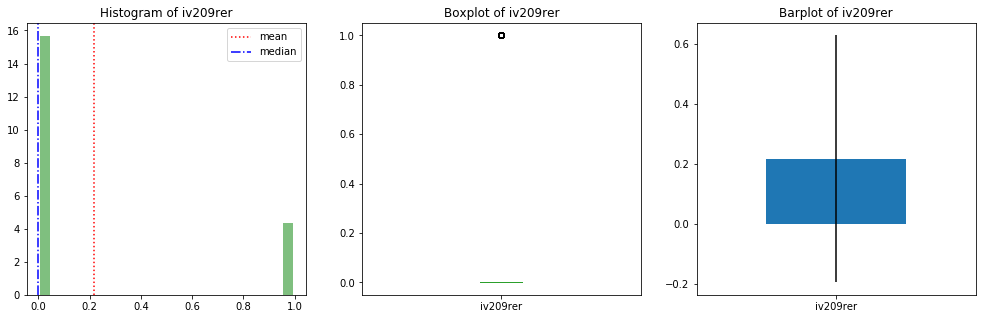

0.0    5173
1.0     684
Name: iv210rer, dtype: int64


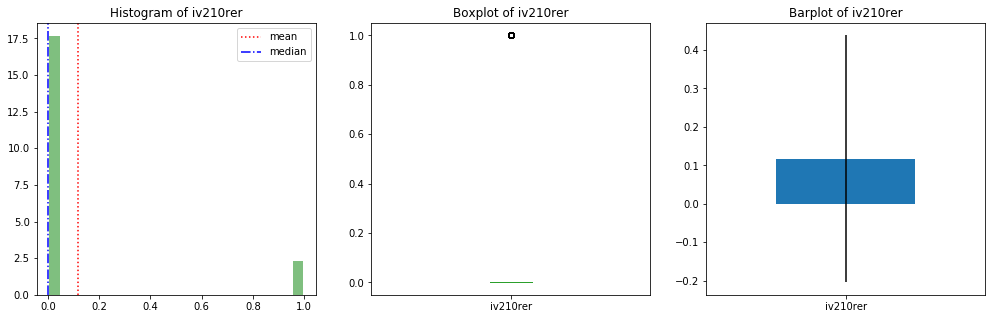

0.0    5012
1.0     845
Name: iv211rer, dtype: int64


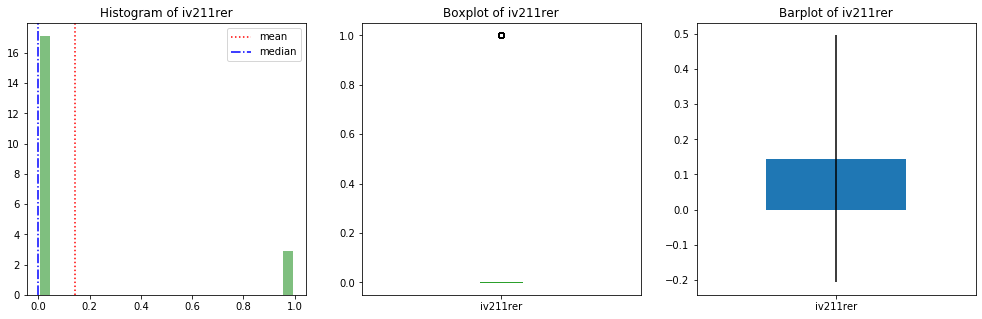

0.0    4763
1.0    1094
Name: iv212rer, dtype: int64


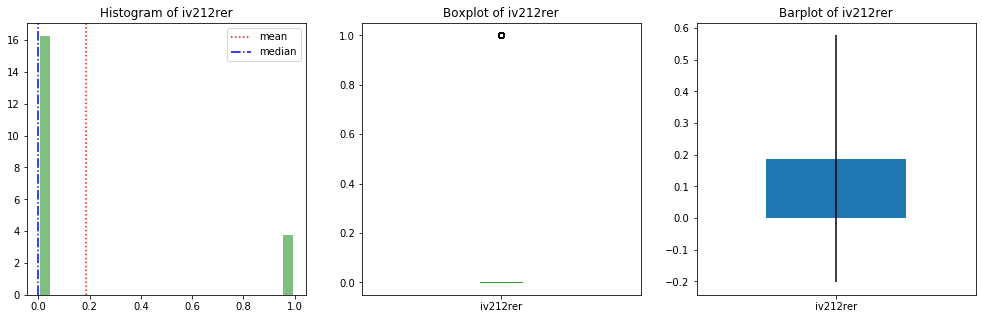

0.0    5441
1.0     416
Name: iv213rer, dtype: int64


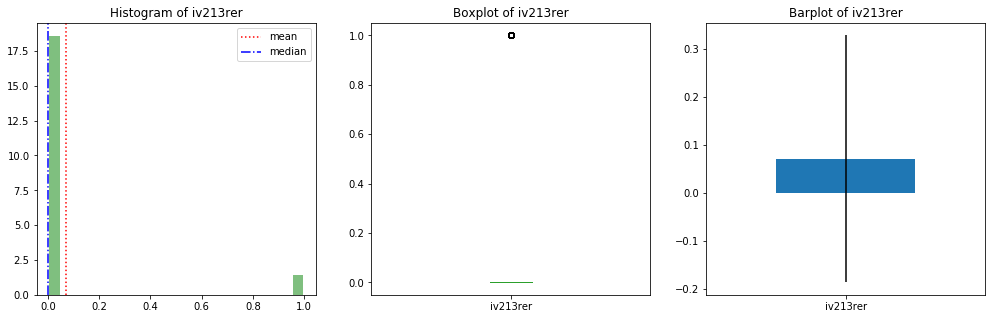

In [0]:
for fea_name in prediction_targets:
  visulize(df, fea_name)

 3.0    3679
 2.0    2030
 1.0      92
-3.0      56
Name: parcntq, dtype: int64


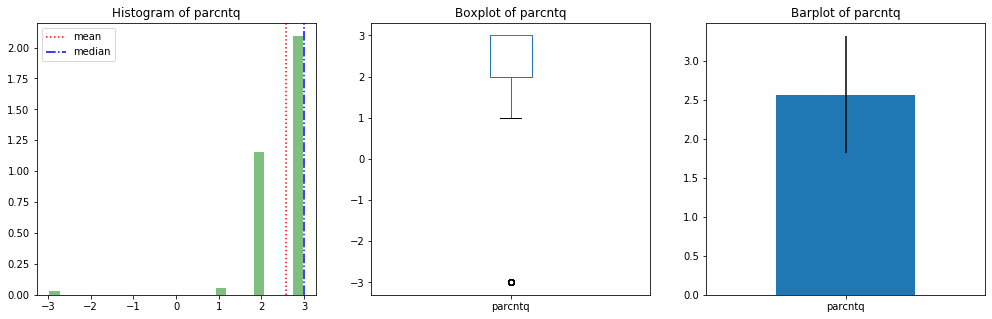

 2.0    3277
 3.0    1870
 1.0     597
-3.0     113
Name: parinfq, dtype: int64


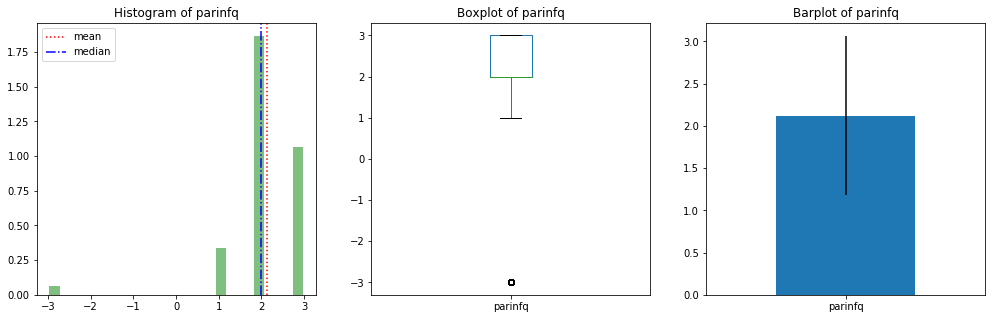

 7.0     2128
 12.0    1067
 10.0     959
 13.0     509
 16.0     362
 14.0     331
 18.0     137
-3.0       96
Name: edfa57q, dtype: int64


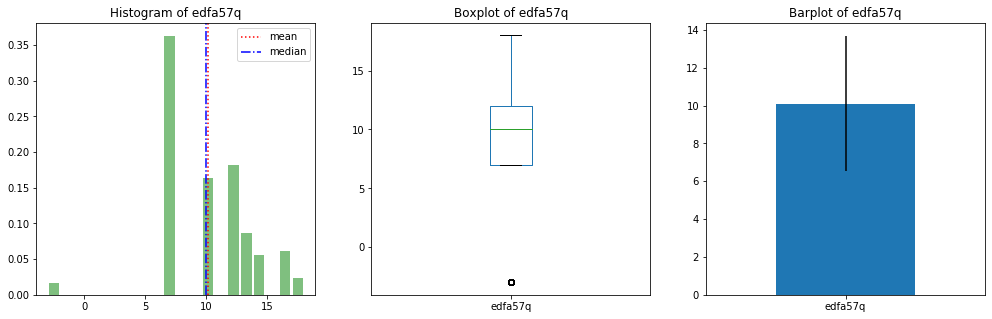

 7.0     1675
 12.0    1567
 10.0    1060
 16.0     513
 13.0     388
 14.0     279
-3.0      105
 18.0      47
Name: edmo57q, dtype: int64


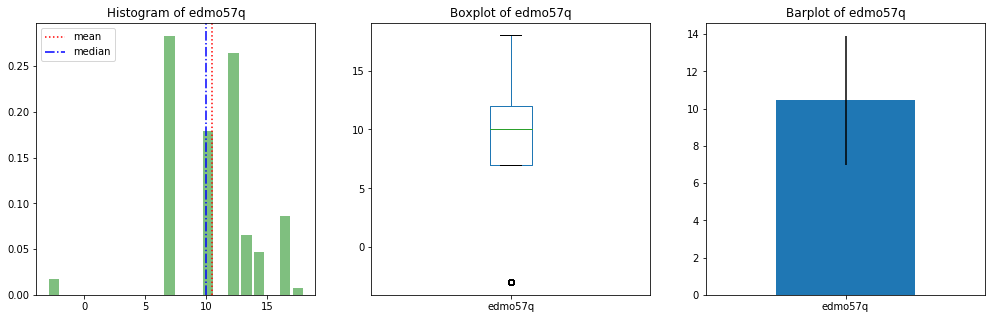

 3.0    4117
 4.0    1113
 2.0     347
-3.0     151
 5.0      99
 1.0      30
Name: sesp57, dtype: int64


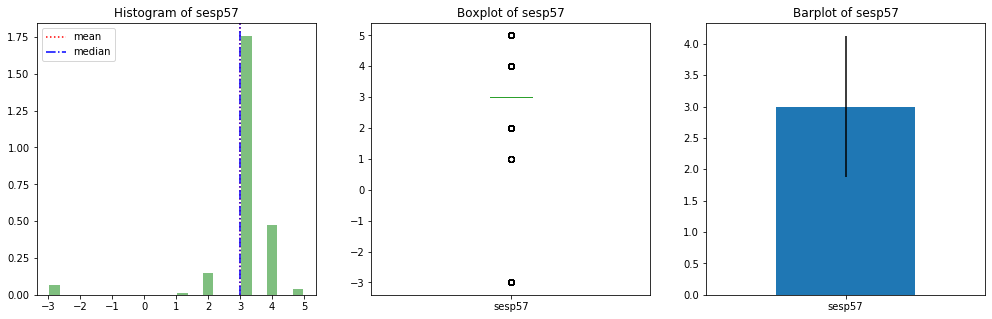

1.0    2225
4.0    1252
2.0    1157
5.0     659
3.0     564
Name: ocf57, dtype: int64


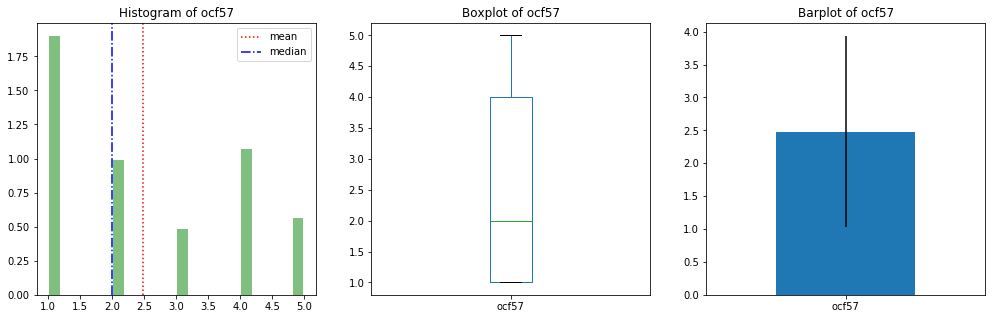

-3.0      675
 41.0      99
 56.0      94
 51.0      85
 55.0      84
         ... 
 269.0      1
 226.0      1
 138.0      1
 356.0      1
 381.0      1
Name: piearl, Length: 275, dtype: int64


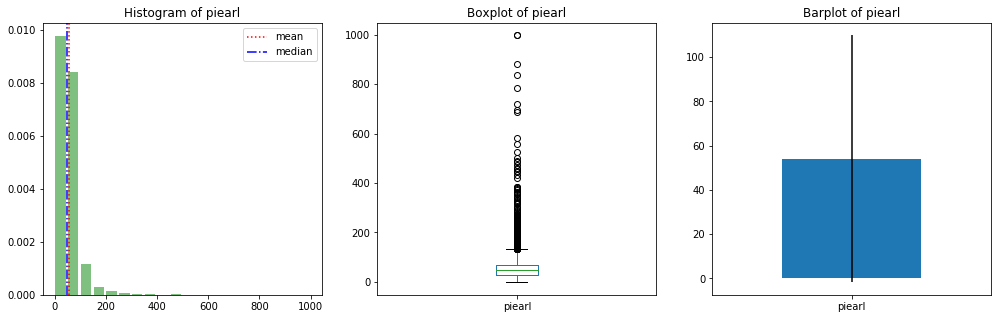

 14.0    1050
-3.0      675
 6.0      361
 44.0     235
 19.0     219
         ... 
 46.0       2
 55.0       2
 74.0       1
 80.0       1
 81.0       1
Name: ocsf57, Length: 88, dtype: int64


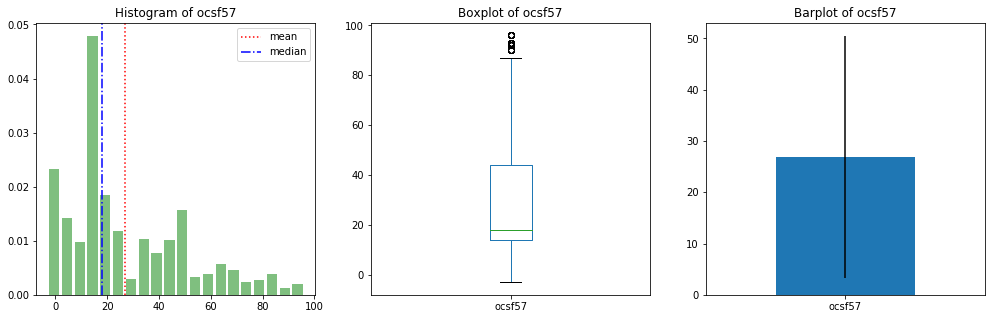

 53.0    1050
-3.0      675
 70.0     395
 41.0     333
 69.0     290
 65.0     263
 57.0     224
 60.0     158
 54.0     153
 58.0     147
 61.0     140
 74.0     138
 67.0     133
 59.0     118
 71.0     112
 77.0     111
 56.0     109
 68.0      93
 55.0      93
 75.0      86
 47.0      82
 83.0      67
 45.0      65
 76.0      62
 66.0      56
 80.0      54
 78.0      50
 72.0      47
 89.0      46
 81.0      45
 43.0      39
 62.0      34
 44.0      34
 84.0      31
 52.0      29
 51.0      29
 85.0      28
 49.0      25
 42.0      25
 64.0      24
 48.0      17
 63.0      17
 34.0      16
 73.0      16
 50.0      15
 46.0      13
 82.0      12
 23.0      10
 93.0      10
 33.0       6
 40.0       5
 79.0       5
 36.0       4
 87.0       4
 86.0       4
 39.0       3
 28.0       2
 38.0       2
 37.0       2
 25.0       1
Name: ocpf57, dtype: int64


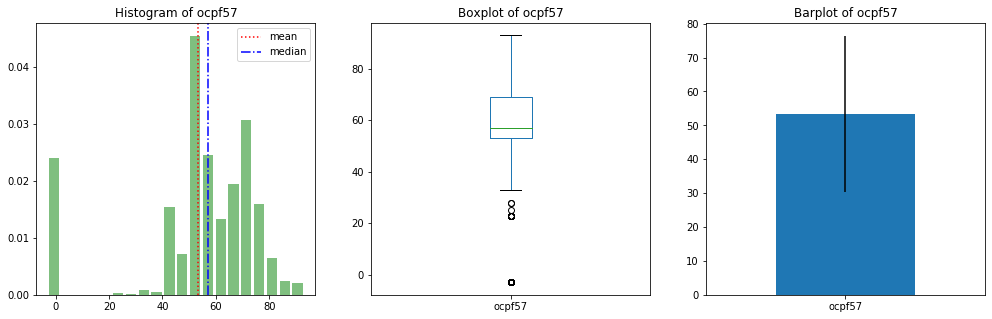

9.0    4206
5.0     606
2.0     320
3.0     218
1.0     200
8.0     180
6.0      36
4.0      33
7.0      29
0.0      29
Name: ocm157, dtype: int64


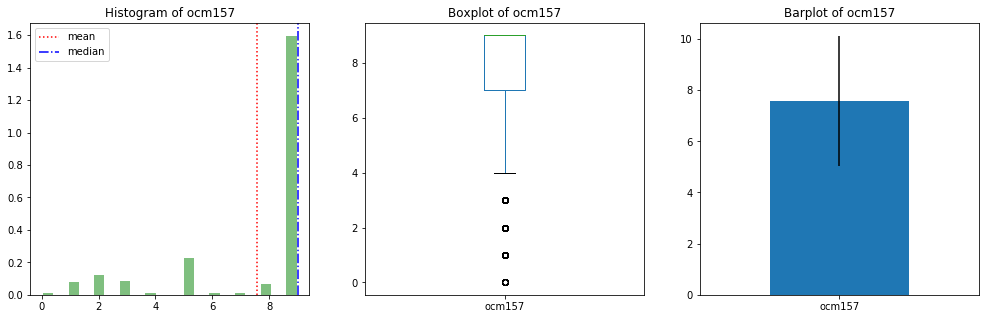

 1.0     2991
-3.0     1206
 44.0     298
 47.0     145
 15.0     122
         ... 
 92.0       1
 84.0       1
 42.0       1
 69.0       1
 93.0       1
Name: ocsmo5, Length: 72, dtype: int64


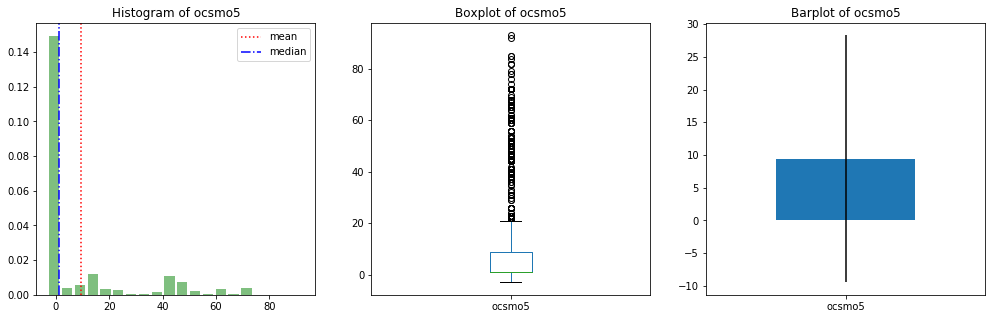

 1.0     2991
-3.0     1206
 69.0     315
 70.0     187
 54.0     122
 78.0     114
 74.0      98
 55.0      88
 52.0      72
 57.0      58
 41.0      57
 71.0      51
 59.0      50
 48.0      41
 47.0      38
 53.0      37
 45.0      34
 60.0      30
 42.0      28
 67.0      28
 50.0      24
 56.0      24
 68.0      23
 44.0      12
 49.0      12
 77.0      10
 72.0      10
 75.0       9
 51.0       8
 58.0       8
 62.0       7
 64.0       6
 40.0       6
 36.0       5
 66.0       5
 65.0       5
 43.0       5
 39.0       4
 76.0       4
 33.0       3
 80.0       3
 46.0       3
 82.0       3
 83.0       2
 61.0       2
 20.0       2
 63.0       2
 89.0       2
 81.0       1
 79.0       1
 84.0       1
Name: ocpmo5, dtype: int64


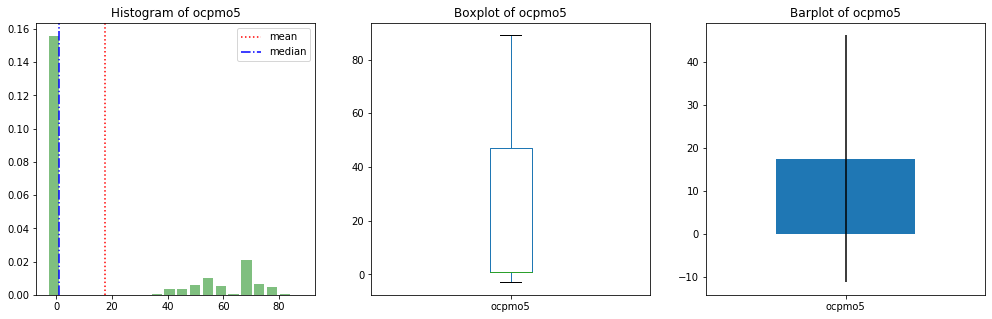

 1.0    5424
 2.0     428
-3.0       5
Name: bklvpr, dtype: int64


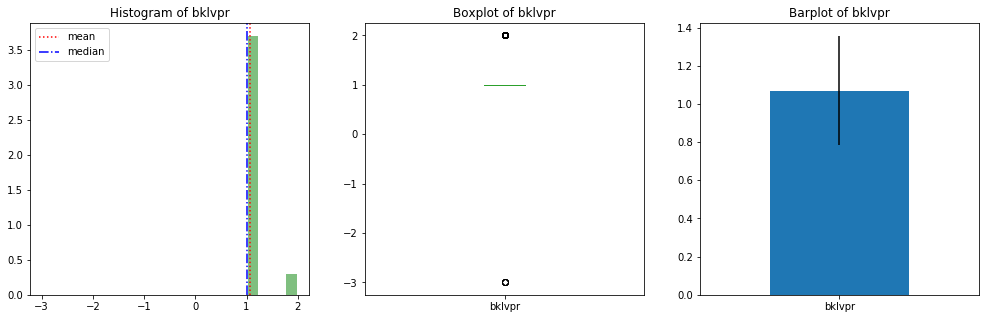

 1.0    5516
 2.0     194
 3.0     131
 4.0      11
-3.0       5
Name: bkhs57, dtype: int64


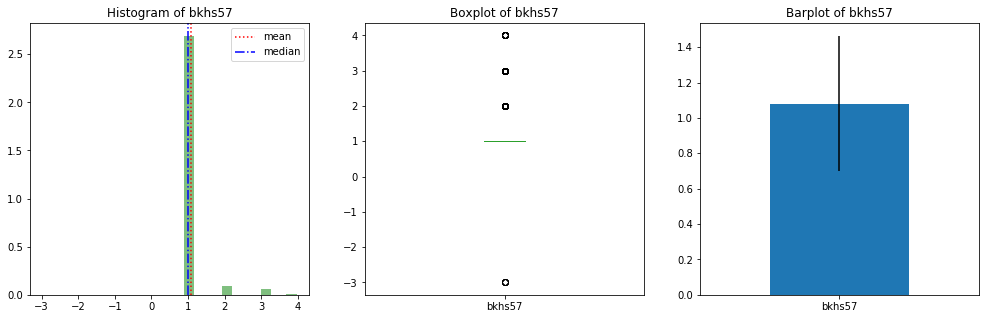

 65.0     432
 63.0     377
 66.0     362
 67.0     321
 62.0     317
 64.0     303
 68.0     283
-3.0      266
 70.0     245
 61.0     238
 69.0     236
 72.0     232
 60.0     221
 75.0     203
 73.0     173
 59.0     159
 58.0     158
 74.0     155
 71.0     155
 77.0     146
 76.0     120
 57.0     100
 79.0      75
 80.0      71
 78.0      69
 56.0      61
 55.0      44
 81.0      40
 85.0      30
 83.0      30
 84.0      25
 82.0      24
 87.0      21
 86.0      18
 89.0      13
 52.0      13
 54.0      13
 53.0       9
 88.0       6
 90.0       5
 91.0       4
 50.0       4
 51.0       3
 94.0       3
 48.0       2
 42.0       2
 49.0       2
 96.0       2
 92.0       1
 100.0      1
 46.0       1
 93.0       1
Name: brdyhh, dtype: int64


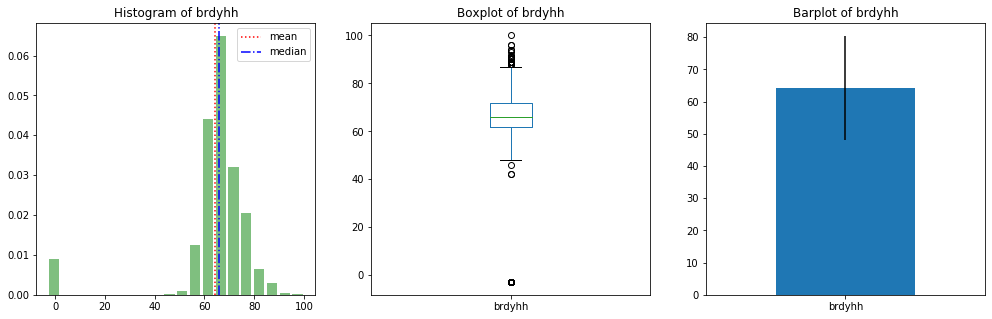

 8.0     1796
 12.0    1432
 6.0      420
 10.0     306
 16.0     257
 14.0     195
 9.0      182
 4.0      181
 7.0      171
 11.0     119
 5.0      112
 3.0       97
 13.0      93
 18.0      58
 15.0      54
 19.0      43
 20.0      32
 17.0      28
 2.0       20
 0.0        9
-3.0        8
 21.0       7
 22.0       7
 24.0       4
 32.0       1
 1.0        1
 26.0       1
 25.0       1
Name: edhhyr, dtype: int64


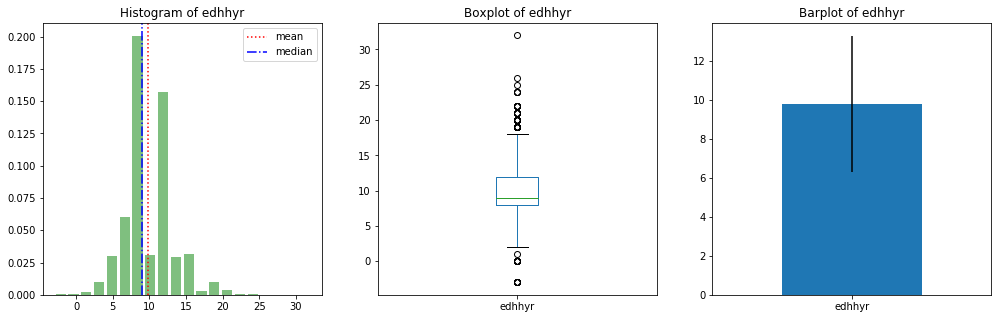

 1.0    5323
 2.0     266
-3.0     264
Name: bkhhw5, dtype: int64


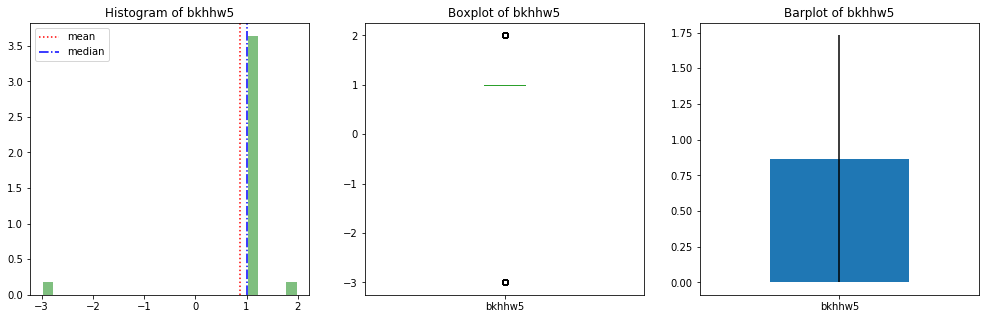

 1.0    3276
 4.0    1875
 2.0     458
 3.0     207
-3.0      12
 5.0       5
Name: cwhh57u, dtype: int64


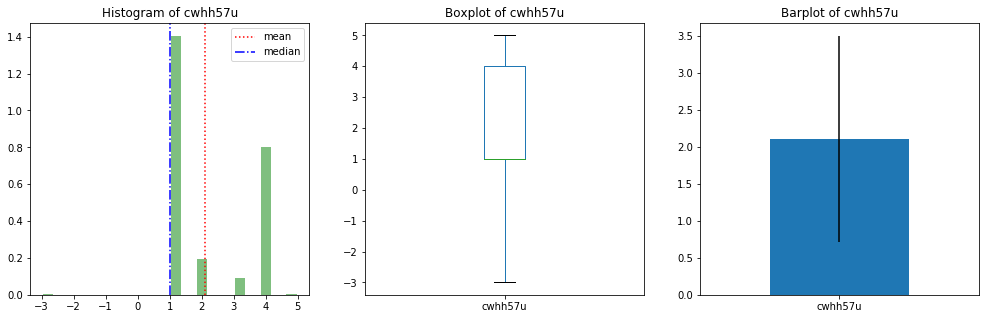

 4.0     2043
 1.0     1176
 6.0      876
 3.0      436
 5.0      410
 12.0     288
 11.0     214
 7.0      137
 8.0       97
 9.0       93
 2.0       33
 10.0      19
-3.0       13
Name: inmh57u, dtype: int64


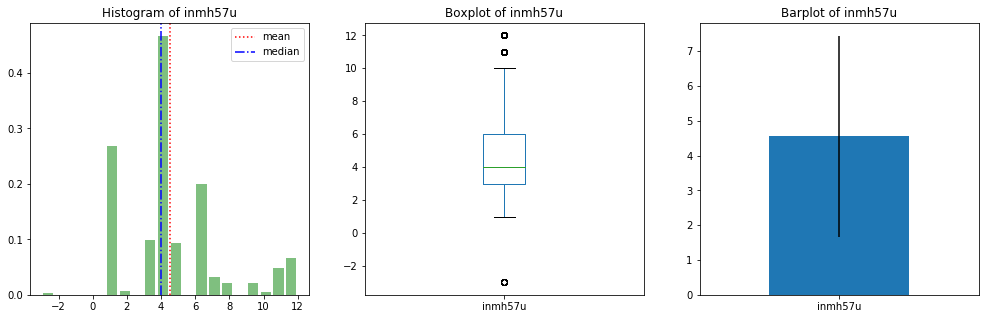

 16.0    1123
 11.0     753
 8.0      632
 4.0      513
 3.0      416
 10.0     342
 2.0      323
 12.0     296
 13.0     276
 9.0      270
 7.0      230
 5.0      183
 15.0     118
 1.0      115
 14.0     109
 6.0       82
-3.0       40
 17.0      36
Name: ocmh57u, dtype: int64


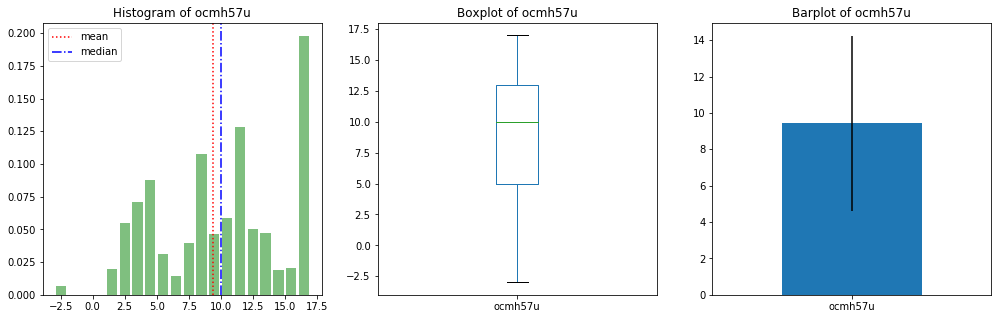

140.0    1135
190.0     169
440.0     158
790.0     127
151.0     126
         ... 
263.0       1
395.0       1
810.0       1
122.0       1
494.0       1
Name: ocsh57u2, Length: 207, dtype: int64


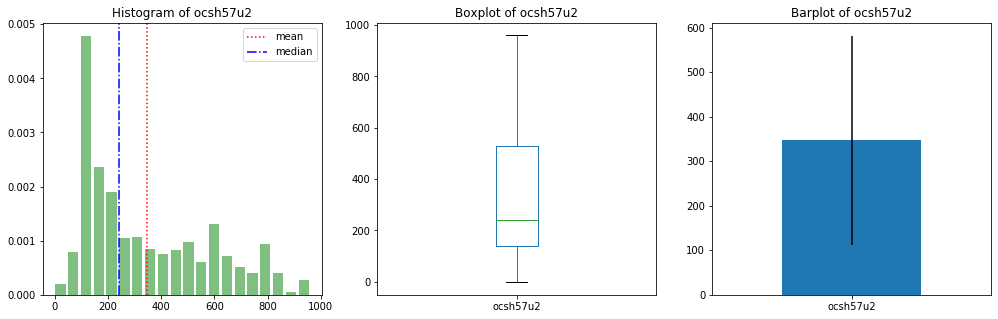

407.0    1122
451.0     210
605.0     166
321.0     126
387.0     119
         ... 
217.0       1
433.0       1
219.0       1
536.0       1
294.0       1
Name: ocph57u2, Length: 224, dtype: int64


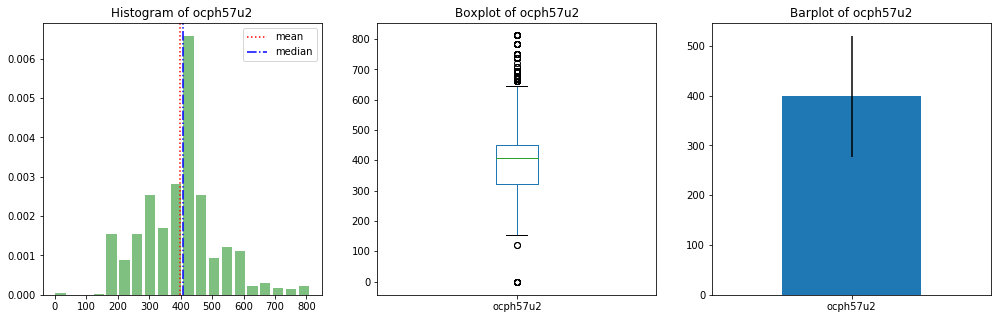

107.0    1125
74.0      154
77.0      121
54.0      120
60.0       92
         ... 
947.0       1
101.0       1
27.0        1
183.0       1
20.0        1
Name: oceh57, Length: 286, dtype: int64


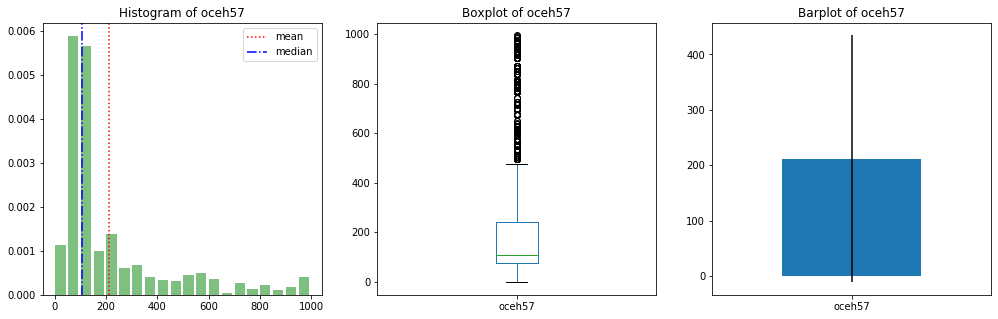

204.0    1122
202.0     138
233.0     110
151.0     107
282.0      93
         ... 
552.0       1
150.0       1
101.0       1
123.0       1
227.0       1
Name: ocih57, Length: 316, dtype: int64


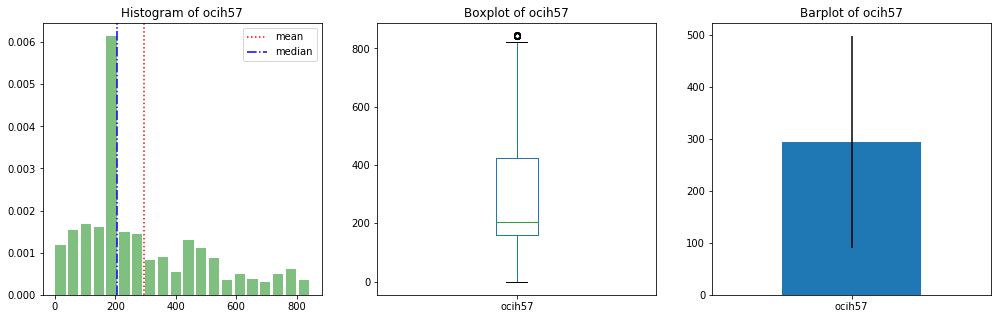

 14.0    2805
 1.0      494
 5.0      454
 15.0     371
 4.0      347
 12.0     183
 16.0     161
 8.0      146
 6.0      134
 7.0      107
 2.0       88
 24.0      72
 11.0      64
 10.0      61
 28.0      39
 3.0       38
 19.0      36
 17.0      28
-3.0       18
 27.0      18
 22.0      16
 18.0      16
 38.0      15
 40.0      13
 36.0      10
 41.0      10
 37.0       8
 23.0       7
 26.0       7
 39.0       7
 9.0        4
 20.0       4
 13.0       4
 25.0       3
 35.0       2
 33.0       1
 30.0       1
 29.0       1
 34.0       1
 32.0       1
Name: natfth, dtype: int64


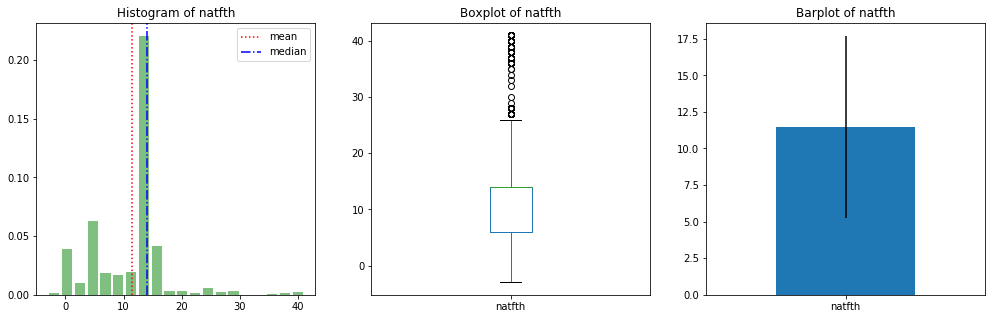

 1.0    2828
 2.0    2434
-3.0     278
 3.0     273
 4.0      31
 5.0       8
Name: zparnf, dtype: int64


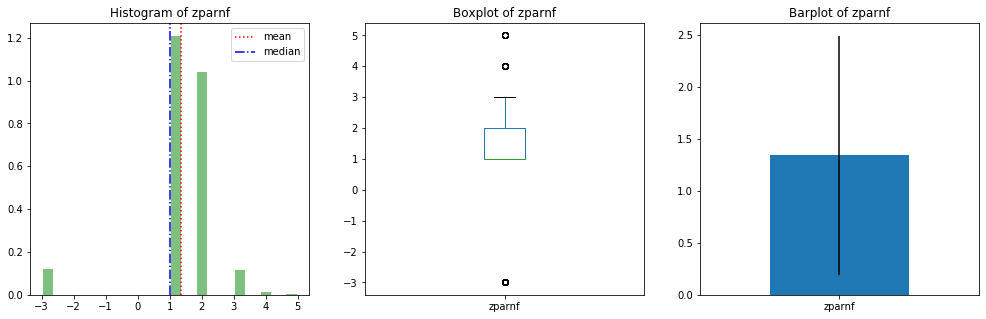

In [0]:
for fea_name in features:
  visulize(df, fea_name)

###Impute missing value

In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=2019)

SI_median = SimpleImputer(missing_values=np.nan, strategy='median')
SI_median.fit(df_train.loc[:,prediction_targets+features])
df_train.loc[:,prediction_targets+features] = SI_median.transform(df_train.loc[:,prediction_targets+features])
df_test.loc[:,prediction_targets+features] = SI_median.transform(df_test.loc[:,prediction_targets+features])

SI_mean = SimpleImputer(missing_values=-3, strategy='mean')
SI_mean.fit(df_train.loc[:,num_features])
df_train.loc[:,num_features] = SI_mean.transform(df_train.loc[:,num_features])
df_test.loc[:,num_features] = SI_mean.transform(df_test.loc[:,num_features])

scalar = Normalizer()
scalar.fit(df_train.loc[:,num_features])
df_train.loc[:,num_features] = scalar.transform(df_train.loc[:,num_features])
df_test.loc[:,num_features] = scalar.transform(df_test.loc[:,num_features])

def df_category(df, cat_features):
    df = pd.get_dummies(df, columns=cat_features)
    return df
    
df_test = df_category(df_test, cat_features+ord_features)
df_train = df_category(df_train, cat_features+ord_features)

for col in df_train.columns:
  if col not in df_test.columns:
    df_test[col] = np.zeros(1172, dtype=np.int32)

In [0]:
df_train.iloc[:, 6:] = df_train.reindex(sorted(df_train.columns[6:]), axis=1)
df_test.iloc[:, 6:] = df_test.reindex(sorted(df_test.columns[6:]), axis=1)

### Models

In [0]:
def plot_roc(pred_proba,y,title):
    fpr, tpr, _ = roc_curve(y, pred_proba) 
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)'% roc_auc,color='red')
    
    plt.plot([0,1],[0,1],'k--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + 'Receiver Operating Characteristic (ROC)')
    
    plt.legend(loc="lower right") 
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title,
                          cmap=plt.cm.Reds):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
from sklearn.utils import resample
def Resample(df, col):
  df_minority_idx = np.where(df[col]==1)[0]
  df_majority_idx = np.where(df[col]==0)[0]
  maj_take = resample(pd.DataFrame(np.take(df, df_majority_idx, axis=0)), replace=True, n_samples=1000, random_state=2019)
  min_take = resample(pd.DataFrame(np.take(df, df_minority_idx, axis=0)),replace=True, n_samples=1000, random_state=2019)
  df_final = pd.concat([maj_take, min_take], axis=0)
  return df_final

####Decision Tree

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iv208rer Training Accuracy:64.95%


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


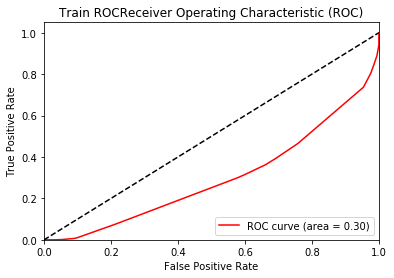

iv208rer Test Accuracy:51.75%


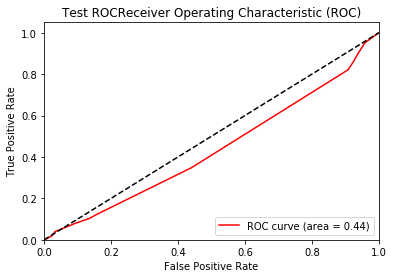

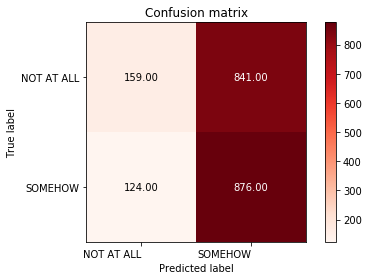

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iv209rer Training Accuracy:64.85%


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


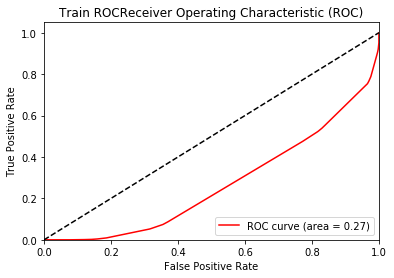

iv209rer Test Accuracy:53.35%


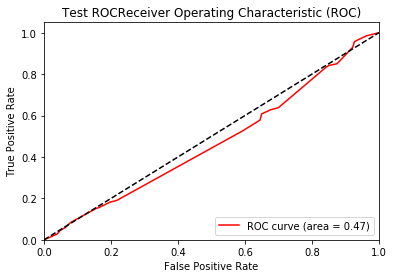

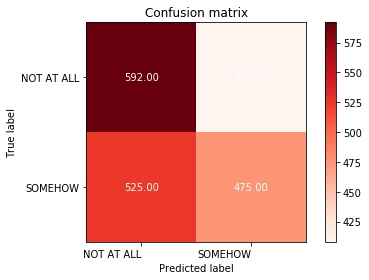

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iv210rer Training Accuracy:61.35%


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


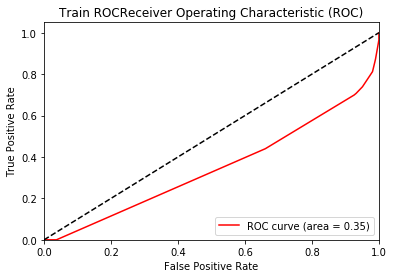

iv210rer Test Accuracy:51.00%


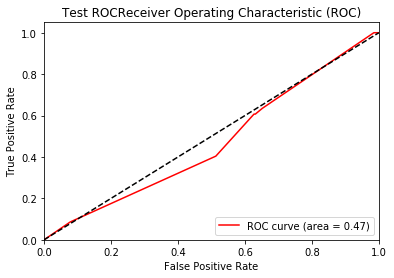

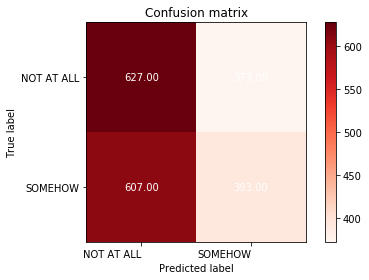

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iv211rer Training Accuracy:71.40%


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


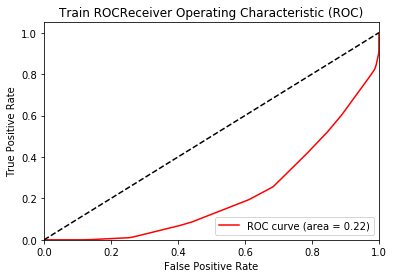

iv211rer Test Accuracy:50.85%


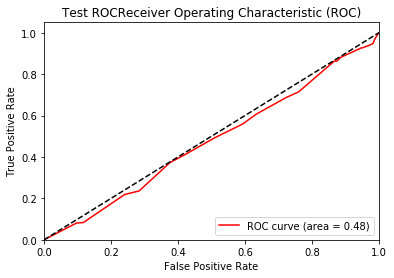

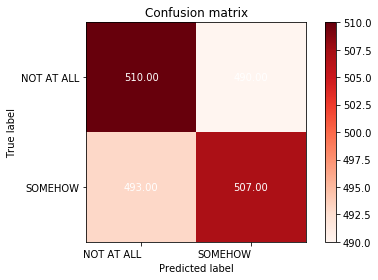

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iv212rer Training Accuracy:67.20%


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


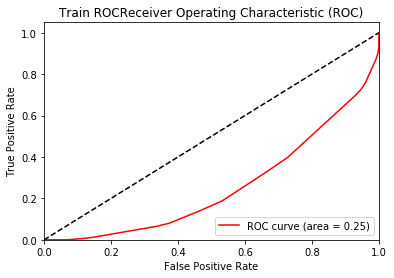

iv212rer Test Accuracy:50.40%


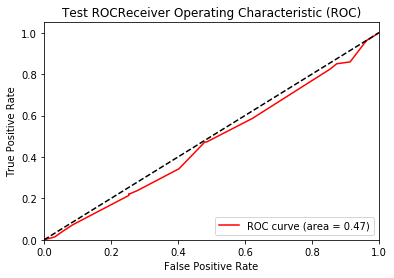

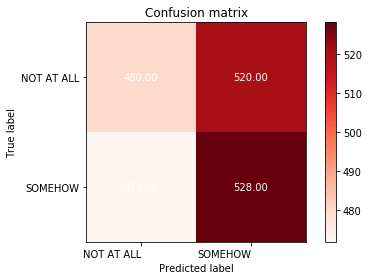

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iv213rer Training Accuracy:64.05%


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


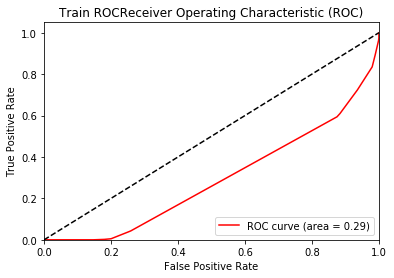

iv213rer Test Accuracy:50.15%


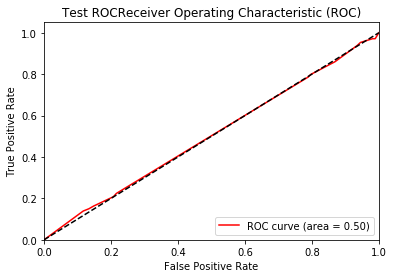

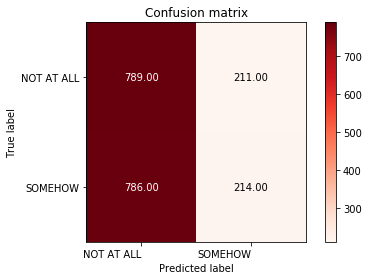

In [0]:
for col in prediction_targets:
  dt_clf = DecisionTreeClassifier()
  param_grid = {'max_depth': [2,3,4,5,6]}
  df_final = Resample(df_train, col)

  X_train = df_final.iloc[:,6:]
  y_train = df_final[col]

  dt_clf = RandomizedSearchCV(dt_clf, param_grid, cv=5, n_iter=100, verbose=1)
  dt_clf.fit(X_train, y_train)
  print(f'{col} Training Accuracy:{accuracy_score(y_train,dt_clf.predict(X_train)):.2%}')
  plot_roc(dt_clf.predict_proba(X_train)[:,0], y_train, 'Train ROC')

  df_final = Resample(df_test, col)

  X_test = df_final.iloc[:,6:]
  y_test = df_final[col]

  print(f'{col} Test Accuracy:{accuracy_score(y_test,dt_clf.predict(X_test)):.2%}')
  pred = dt_clf.predict(X_test)
  plot_roc(dt_clf.predict_proba(X_test)[:,0], y_test, 'Test ROC')

  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_test, pred, classes=['NOT AT ALL', 'SOMEHOW'], title='Confusion matrix')
  plt.show()


####Random Forest

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   30.5s finished


iv208rer Training Accuracy:75.65%


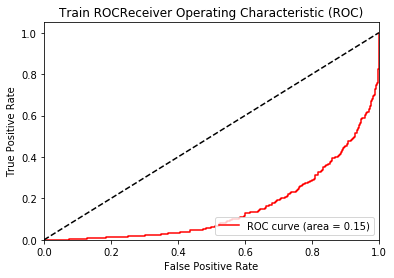

iv208rer Test Accuracy:54.75%


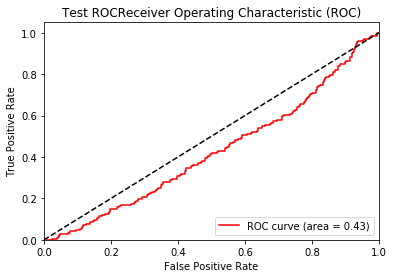

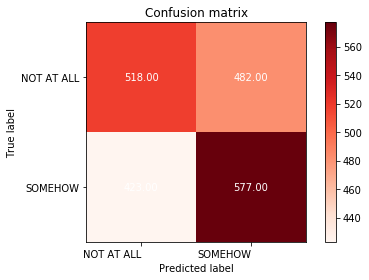

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   30.7s finished


iv209rer Training Accuracy:76.25%


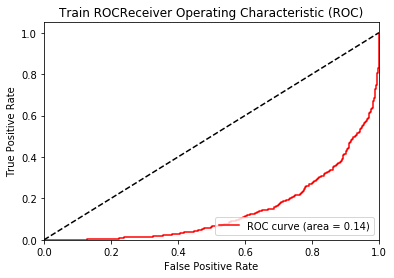

iv209rer Test Accuracy:55.50%


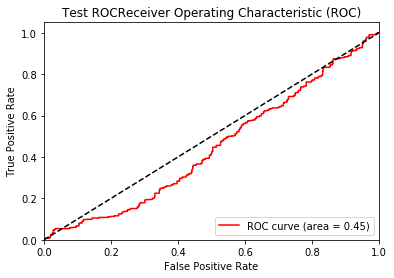

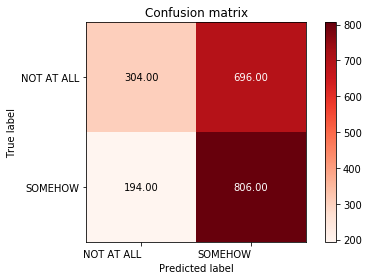

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   30.2s finished


iv210rer Training Accuracy:77.00%


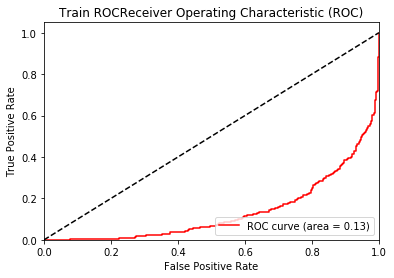

iv210rer Test Accuracy:54.30%


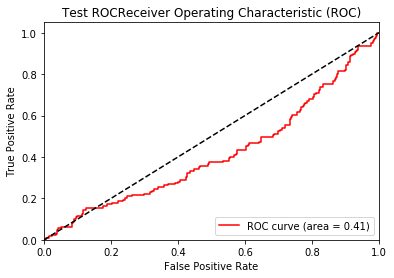

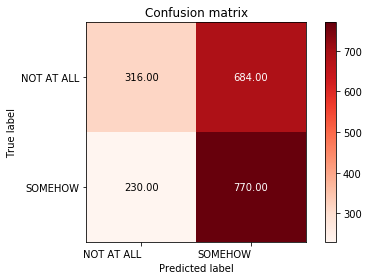

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   30.6s finished


iv211rer Training Accuracy:75.00%


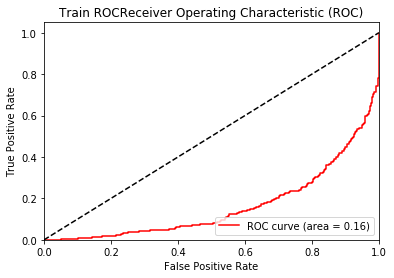

iv211rer Test Accuracy:53.20%


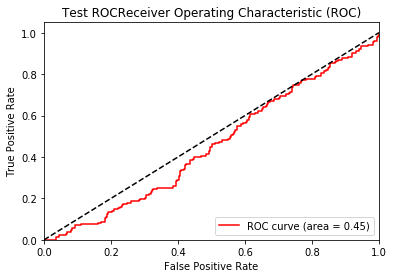

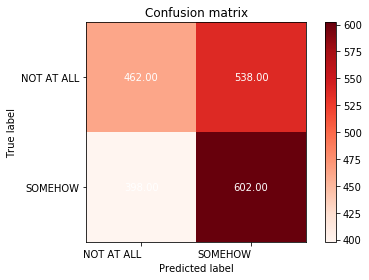

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   30.2s finished


iv212rer Training Accuracy:72.10%


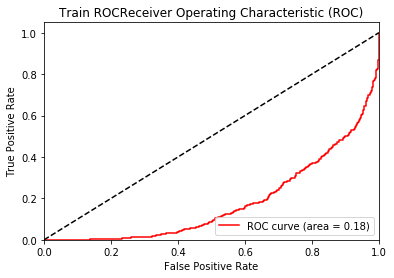

iv212rer Test Accuracy:54.65%


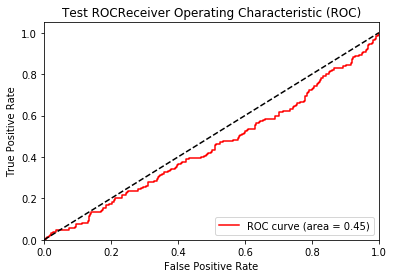

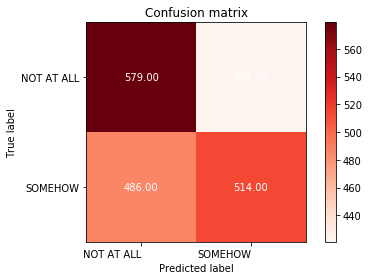

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   30.0s finished


iv213rer Training Accuracy:78.40%


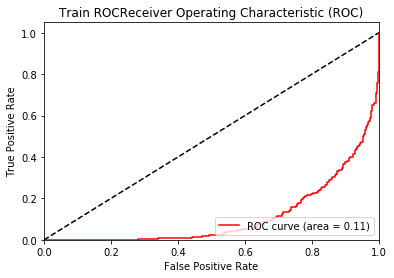

iv213rer Test Accuracy:51.80%


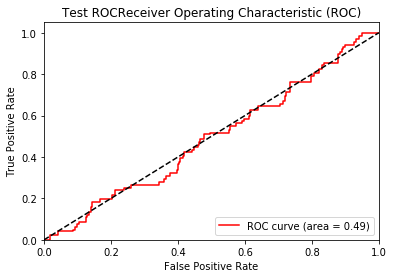

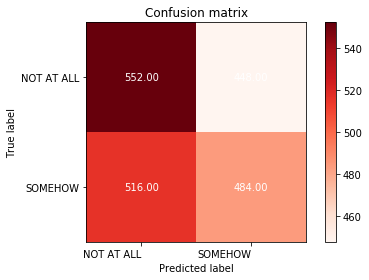

In [0]:
np.random.seed(2019)
for col in prediction_targets:
  rf_clf = RandomForestClassifier()
  param_grid = {'n_estimators': [200, 250, 300],
                'max_depth': np.asarray(np.linspace(1,5,5), np.int32),
                'random_state': [2019]}
                
  df_final = Resample(df_train, col)

  X_train = df_final.iloc[:,6:]
  y_train = df_final[col]

  rf_clf = RandomizedSearchCV(rf_clf, param_grid, cv=5, n_iter=100, verbose=1)
  rf_clf.fit(X_train, y_train)
  print(f'{col} Training Accuracy:{accuracy_score(y_train,rf_clf.predict(X_train)):.2%}')
  plot_roc(rf_clf.predict_proba(X_train)[:,0], y_train, 'Train ROC')

  df_final = Resample(df_test, col)

  X_test = df_final.iloc[:,6:]
  y_test = df_final[col]

  print(f'{col} Test Accuracy:{accuracy_score(y_test,rf_clf.predict(X_test)):.2%}')
  pred = rf_clf.predict(X_test)
  plot_roc(rf_clf.predict_proba(X_test)[:,0], y_test, 'Test ROC')

  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_test, pred, classes=['NOT AT ALL', 'SOMEHOW'], title='Confusion matrix')
  plt.show()

####Gradient Boost 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   13.0s finished


iv208rer Training Accuracy:94.90%


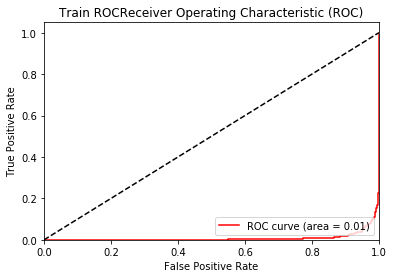

iv208rer Test Accuracy:52.80%


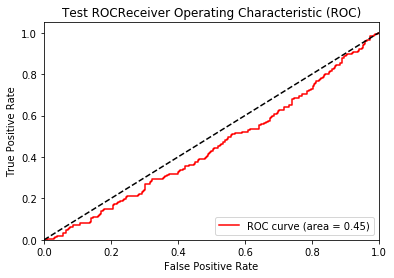

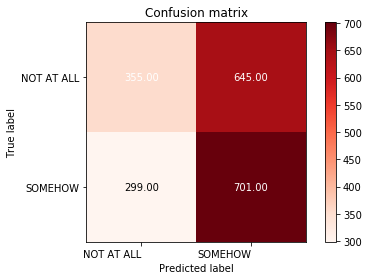

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   13.1s finished


iv209rer Training Accuracy:95.95%


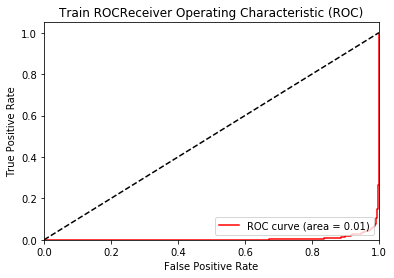

iv209rer Test Accuracy:54.20%


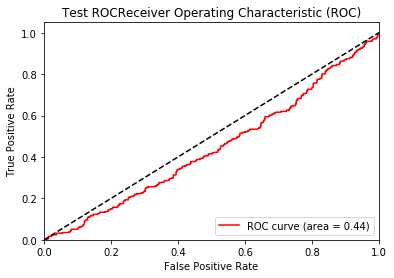

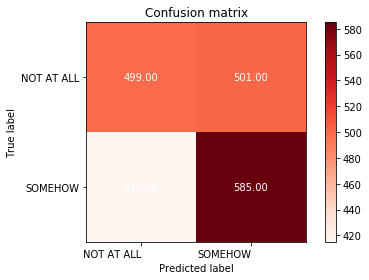

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.0s finished


iv210rer Training Accuracy:96.95%


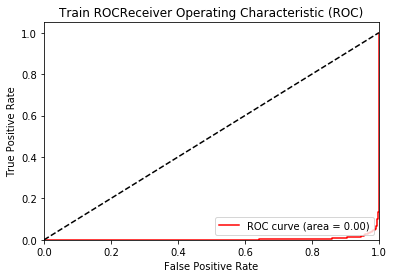

iv210rer Test Accuracy:49.25%


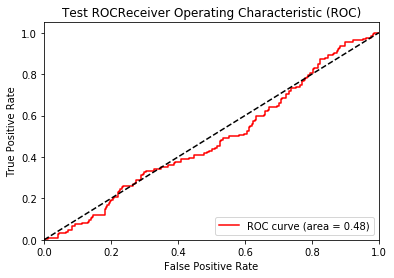

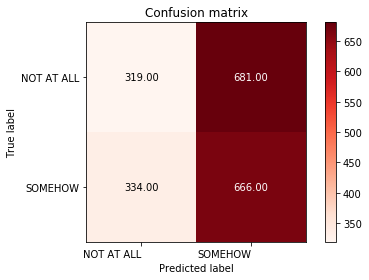

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.6s finished


iv211rer Training Accuracy:97.30%


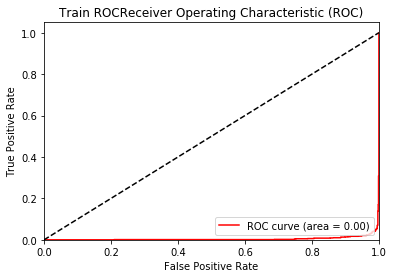

iv211rer Test Accuracy:53.35%


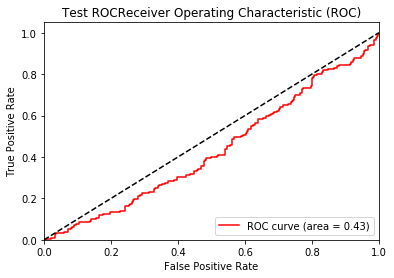

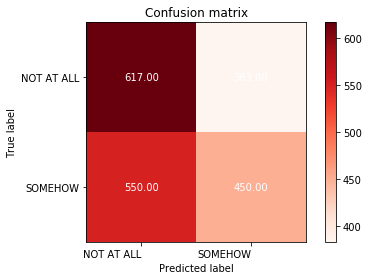

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.9s finished


iv212rer Training Accuracy:94.85%


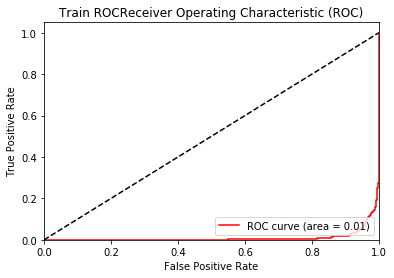

iv212rer Test Accuracy:53.90%


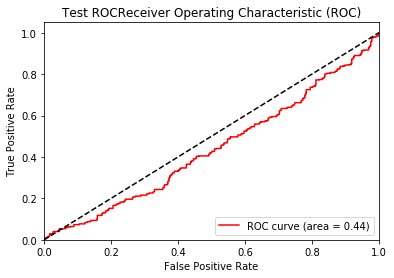

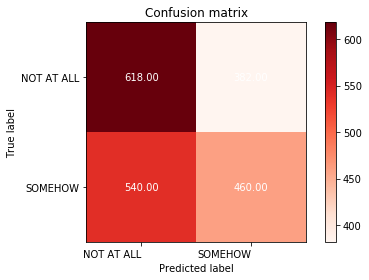

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   12.1s finished


iv213rer Training Accuracy:98.60%


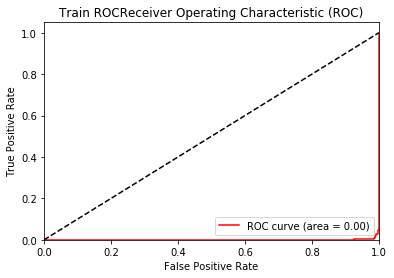

iv213rer Test Accuracy:47.20%


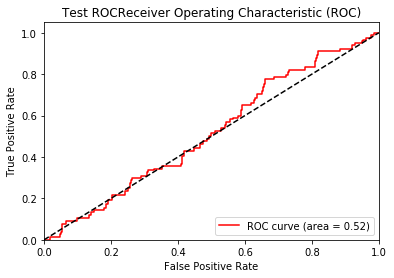

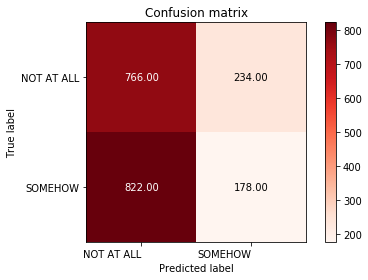

In [0]:
for col in prediction_targets:
  gb_clf = GradientBoostingClassifier()
  param_grid = {'max_depth': np.asarray(np.linspace(1,5,5), dtype=np.int32)}
  df_final = Resample(df_train, col)

  X_train = df_final.iloc[:,6:]
  y_train = df_final[col]

  gb_clf = RandomizedSearchCV(gb_clf, param_grid, cv=5, n_iter=100, verbose=1)
  gb_clf.fit(X_train, y_train)
  print(f'{col} Training Accuracy:{accuracy_score(y_train,gb_clf.predict(X_train)):.2%}')
  plot_roc(gb_clf.predict_proba(X_train)[:,0], y_train, 'Train ROC')

  df_final = Resample(df_test, col)

  X_test = df_final.iloc[:,6:]
  y_test = df_final[col]

  print(f'{col} Test Accuracy:{accuracy_score(y_test,gb_clf.predict(X_test)):.2%}')
  pred = gb_clf.predict(X_test)
  plot_roc(gb_clf.predict_proba(X_test)[:,0], y_test, 'Test ROC')

  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_test, pred, classes=['NOT AT ALL', 'SOMEHOW'], title='Confusion matrix')
  plt.show()

####XGB

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.9s finished


iv208rer Training Accuracy:96.35%


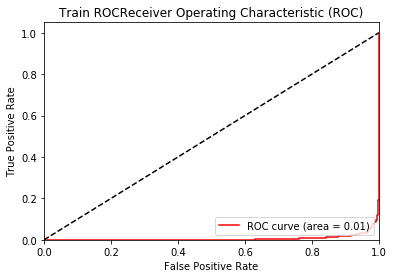

iv208rer Test Accuracy:57.50%


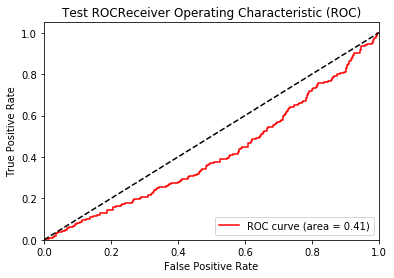

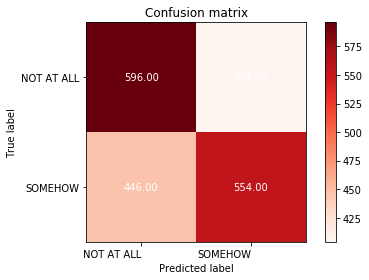

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.6s finished


iv209rer Training Accuracy:96.50%


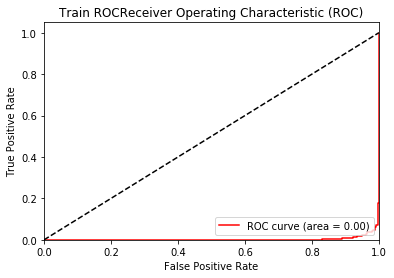

iv209rer Test Accuracy:51.50%


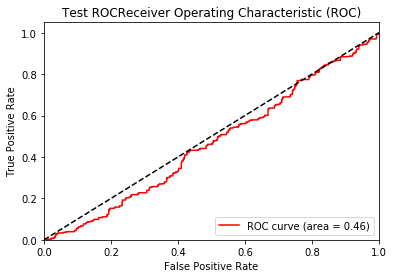

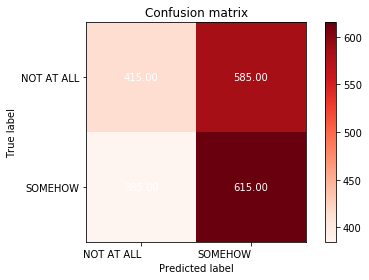

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.6s finished


iv210rer Training Accuracy:98.05%


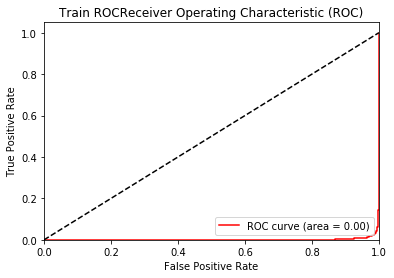

iv210rer Test Accuracy:54.70%


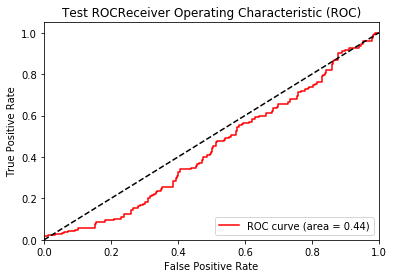

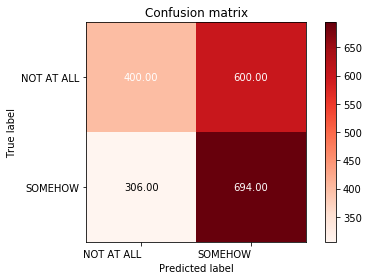

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.7s finished


iv211rer Training Accuracy:97.60%


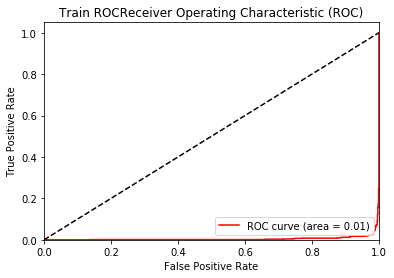

iv211rer Test Accuracy:53.45%


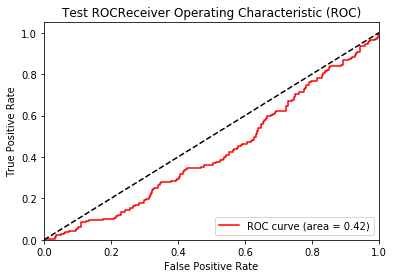

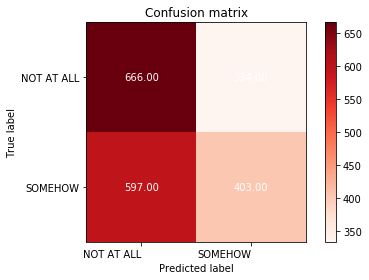

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.8s finished


iv212rer Training Accuracy:96.00%


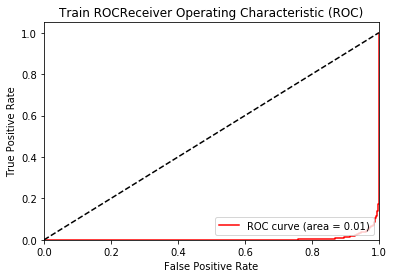

iv212rer Test Accuracy:54.80%


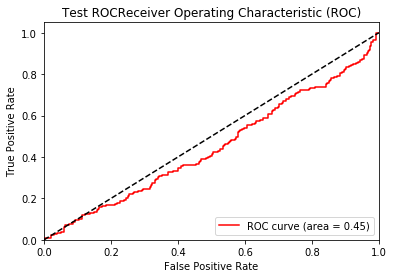

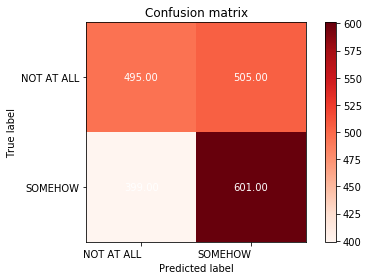

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   17.6s finished


iv213rer Training Accuracy:98.95%


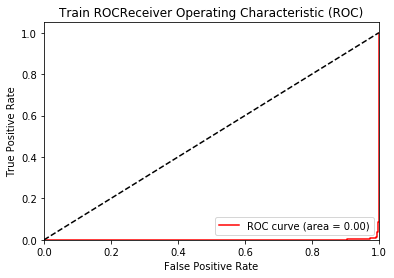

iv213rer Test Accuracy:53.95%


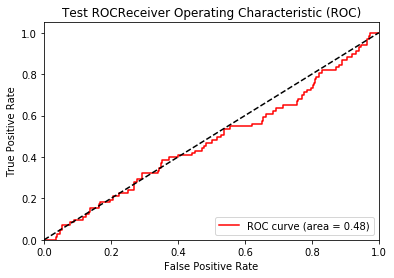

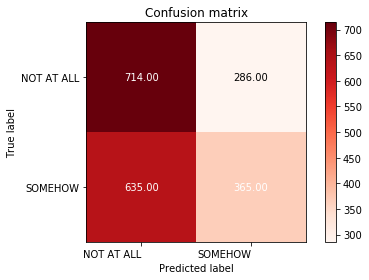

In [0]:
for col in prediction_targets:
  xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=2,seed=20190005)
  param_grid = {'max_depth': np.asarray(np.linspace(1,5,5), dtype=np.int32)}
  df_final = Resample(df_train, col)

  X_train = df_final.iloc[:,6:].values
  y_train = df_final[col]

  xgb_clf = RandomizedSearchCV(xgb_clf, param_grid, cv=5, n_iter=100, verbose=1)
  xgb_clf.fit(X_train, y_train)
  print(f'{col} Training Accuracy:{accuracy_score(y_train,xgb_clf.predict(X_train)):.2%}')
  plot_roc(xgb_clf.predict_proba(X_train)[:,0], y_train, 'Train ROC')

  df_final = Resample(df_test, col)

  X_test = df_final.iloc[:,6:].values
  y_test = df_final[col]

  print(f'{col} Test Accuracy:{accuracy_score(y_test,xgb_clf.predict(X_test)):.2%}')
  pred = xgb_clf.predict(X_test)
  plot_roc(xgb_clf.predict_proba(X_test)[:,0], y_test, 'Test ROC')

  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_test, pred, classes=['NOT AT ALL', 'SOMEHOW'], title='Confusion matrix')
  plt.show()

####NN

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished


iv208rer Training Accuracy:96.05%


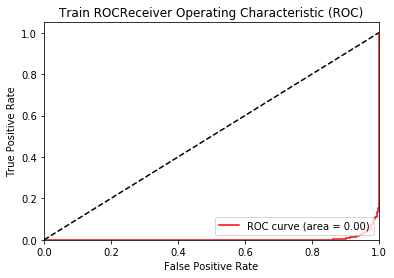

iv208rer Test Accuracy:57.85%


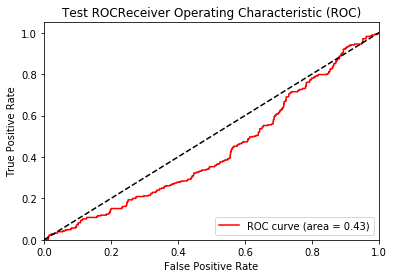

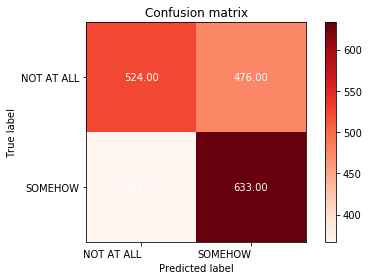

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished


iv209rer Training Accuracy:96.10%


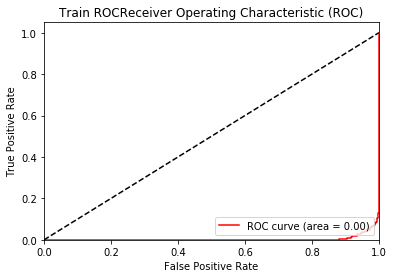

iv209rer Test Accuracy:53.10%


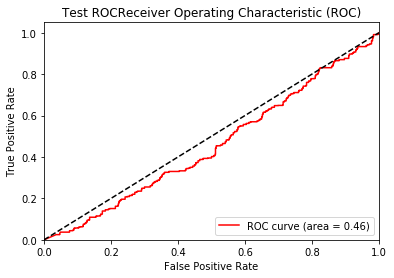

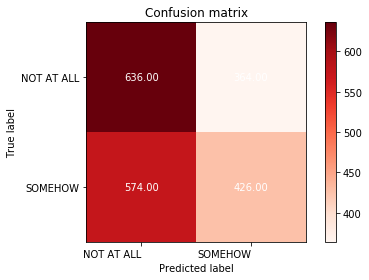

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s finished


iv210rer Training Accuracy:95.45%


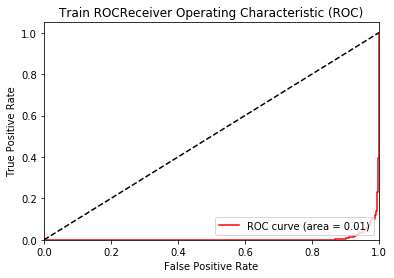

iv210rer Test Accuracy:48.15%


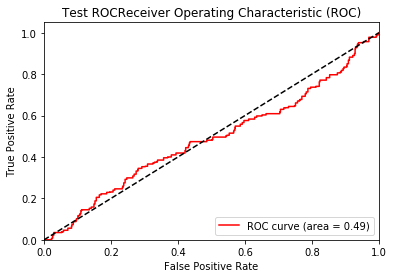

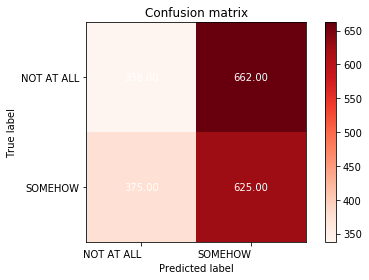

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.9s finished


iv211rer Training Accuracy:97.00%


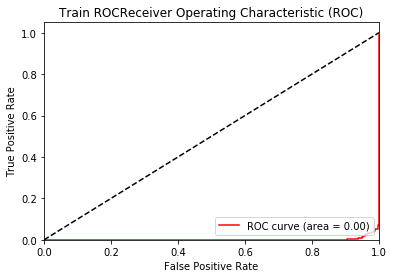

iv211rer Test Accuracy:52.20%


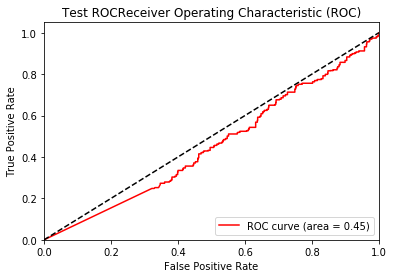

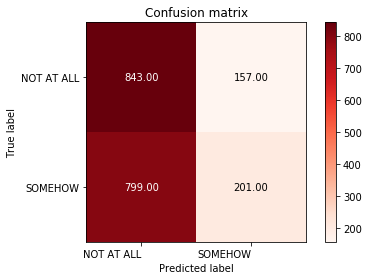

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished


iv212rer Training Accuracy:94.65%


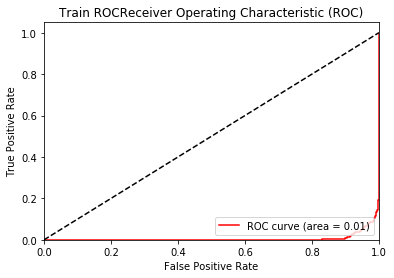

iv212rer Test Accuracy:52.35%


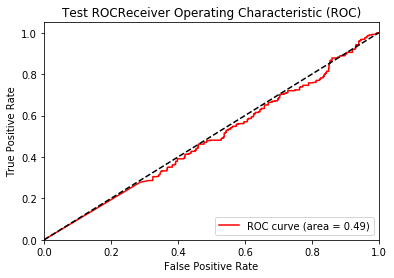

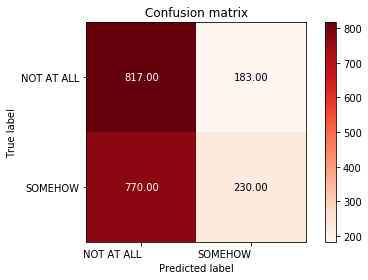

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished


iv213rer Training Accuracy:96.75%


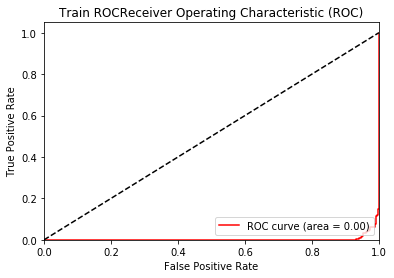

iv213rer Test Accuracy:49.20%


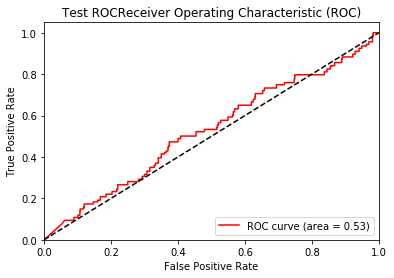

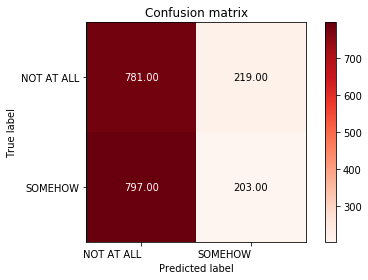

In [0]:
for col in prediction_targets:
  nn_clf = MLPClassifier(hidden_layer_sizes = [50,25,10], activation='relu', solver='adam', 
                      learning_rate_init = 0.01, max_iter = 1500)
  param_grid = {'hidden_layer_sizes': [[50,25,10]],
          'learning_rate_init': [0.01],
          'max_iter': [1500],
          'activation': ['relu'],
          'solver': ['adam']}
          
  df_final = Resample(df_train, col)

  X_train = df_final.iloc[:,6:]
  y_train = df_final[col]

  nn_clf = RandomizedSearchCV(nn_clf, param_grid, cv=5, n_iter=100, verbose=1)
  nn_clf.fit(X_train, y_train)
  print(f'{col} Training Accuracy:{accuracy_score(y_train,nn_clf.predict(X_train)):.2%}')
  plot_roc(nn_clf.predict_proba(X_train)[:,0], y_train, 'Train ROC')

  df_final = Resample(df_test, col)

  X_test = df_final.iloc[:,6:]
  y_test = df_final[col]

  print(f'{col} Test Accuracy:{accuracy_score(y_test,nn_clf.predict(X_test)):.2%}')
  pred = nn_clf.predict(X_test)
  plot_roc(nn_clf.predict_proba(X_test)[:,0], y_test, 'Test ROC')

  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_test, pred, classes=['NOT AT ALL', 'SOMEHOW'], title='Confusion matrix')
  plt.show()

####GAM Softmax

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished


iv208rer Training Accuracy:64.75%


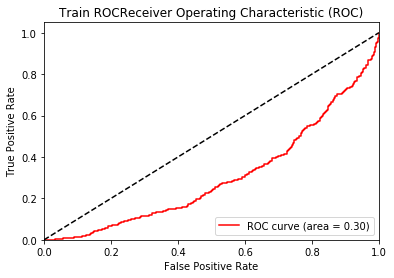

iv208rer Test Accuracy:50.10%


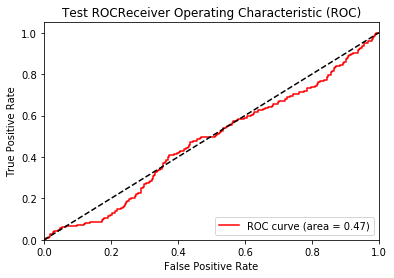

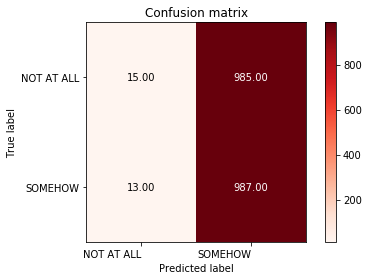

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


iv209rer Training Accuracy:64.45%


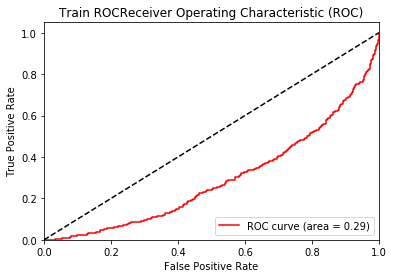

iv209rer Test Accuracy:54.15%


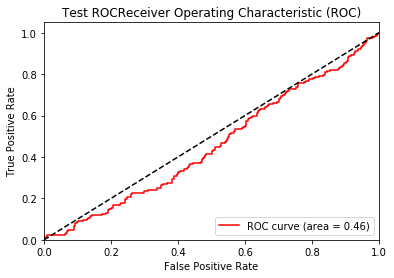

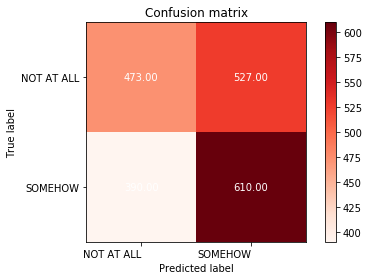

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.1s finished


iv210rer Training Accuracy:64.45%


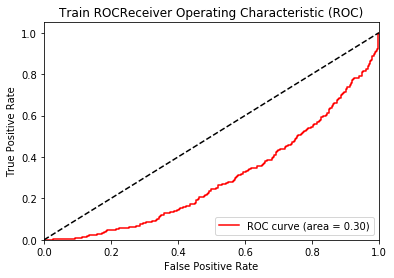

iv210rer Test Accuracy:49.80%


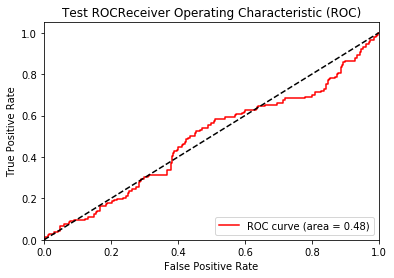

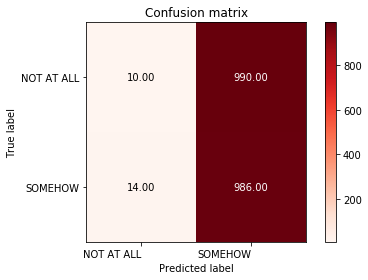

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.8s finished


iv211rer Training Accuracy:65.70%


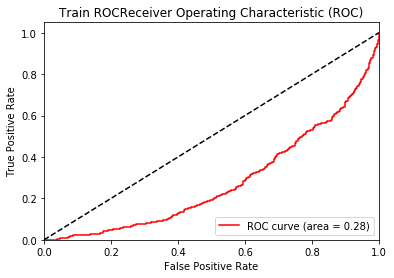

iv211rer Test Accuracy:51.60%


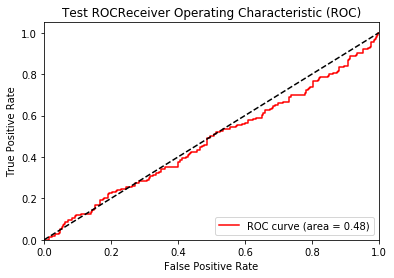

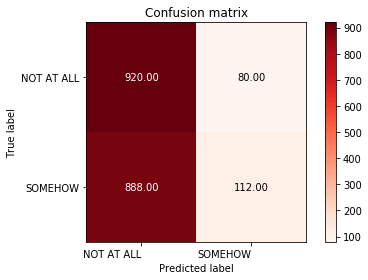

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished


iv212rer Training Accuracy:64.10%


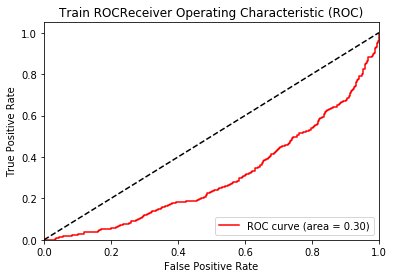

iv212rer Test Accuracy:49.65%


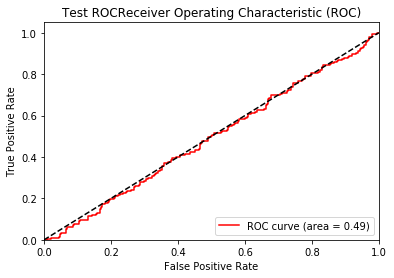

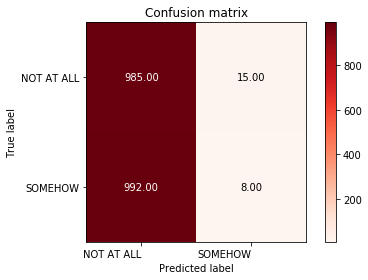

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished


iv213rer Training Accuracy:65.20%


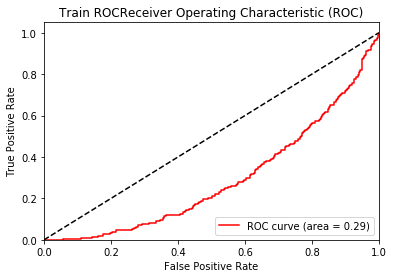

iv213rer Test Accuracy:49.90%


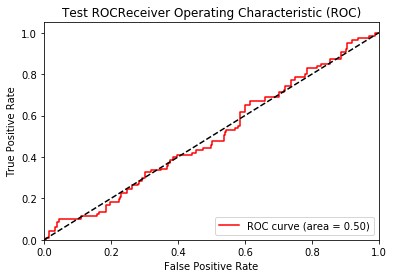

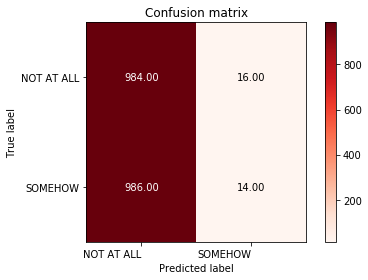

In [0]:
for col in prediction_targets:
  gam_clf = LogisticRegression(penalty='l2', solver='newton-cg')
  param_grid = {'penalty': ['l2', 'none'],
                'solver': ['newton-cg']}
  df_final = Resample(df_train, col)

  X_train = df_final.iloc[:,6:]
  y_train = df_final[col]

  gam_clf = RandomizedSearchCV(gam_clf, param_grid, cv=5, n_iter=100, verbose=1)
  gam_clf.fit(X_train, y_train)
  print(f'{col} Training Accuracy:{accuracy_score(y_train,gam_clf.predict(X_train)):.2%}')
  plot_roc(gam_clf.predict_proba(X_train)[:,0], y_train, 'Train ROC')

  df_final = Resample(df_test, col)

  X_test = df_final.iloc[:,6:]
  y_test = df_final[col]

  print(f'{col} Test Accuracy:{accuracy_score(y_test,gam_clf.predict(X_test)):.2%}')
  pred = gam_clf.predict(X_test)
  plot_roc(gam_clf.predict_proba(X_test)[:,0], y_test, 'Test ROC')

  np.set_printoptions(precision=2)
  plot_confusion_matrix(y_test, pred, classes=['NOT AT ALL', 'SOMEHOW'], title='Confusion matrix')
  plt.show()

##Results Analysis iv208rer

####Set up

In [0]:
n_explain = 1000
col = 'iv208rer'
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=2, seed=20190005)           
df_final = Resample(df_train, col)
X_train = df_final.iloc[:,6:]
y_train = df_final[col]
xgb_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_clf, df_test.iloc[0:n_explain,6:])

In [0]:
shap_values = explainer.shap_values(df_test.iloc[0:n_explain,6:])

 98%|===================| 978/1000 [00:15<00:00]       

###Local interprebility

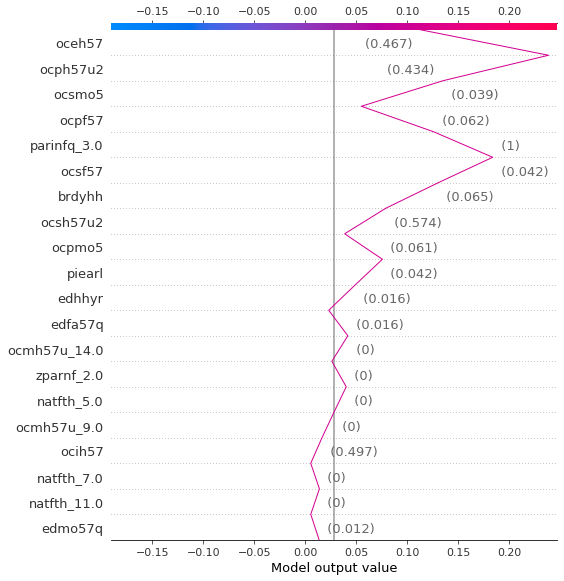

In [0]:
shap.initjs()
i = 10
shap.decision_plot(explainer.expected_value, shap_values[i], df_test.iloc[i,6:])

###Variable Importance and Global Interprebility

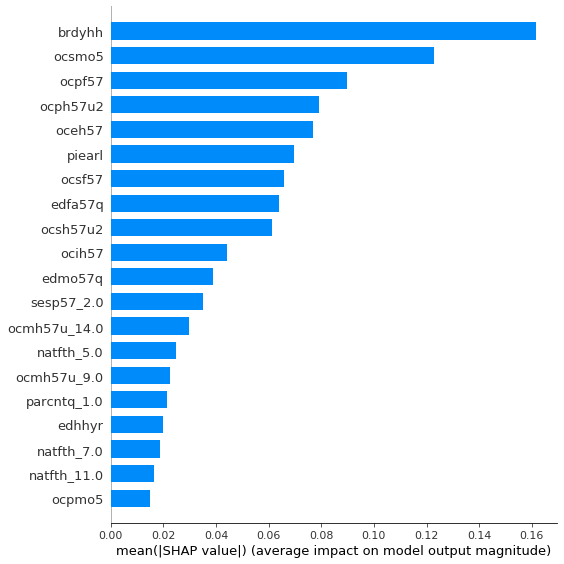

In [0]:
shap.summary_plot(shap_values, feature_names=df_train.columns[6:], plot_type='bar')

### PDP
We will show the shap PDP plots for the first 3 most important variables below. 

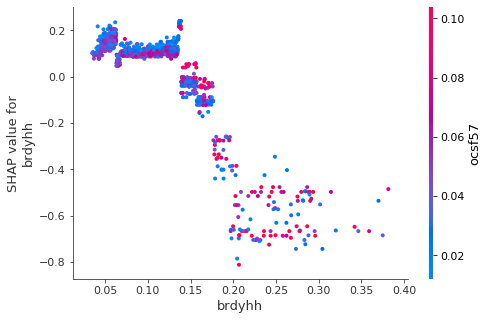

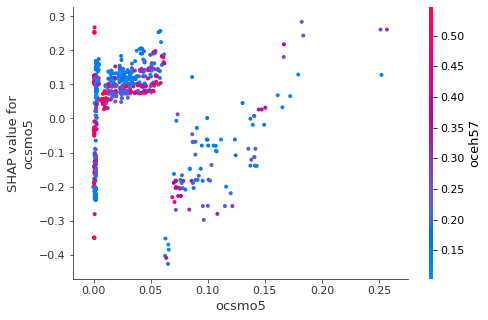

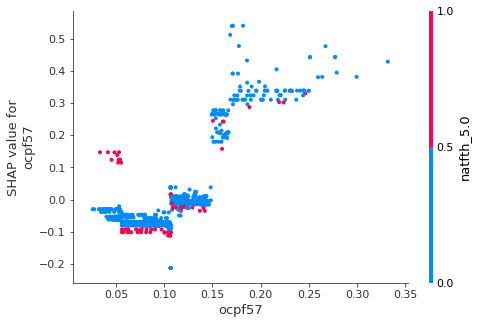

In [0]:
shap.dependence_plot('brdyhh', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('ocsmo5', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('ocpf57', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])

##Results Analysis iv209rer

####Set up

In [0]:
n_explain = 1000
col = 'iv209rer'
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=2019)           
rf_final = Resample(df_train, col)
X_train = df_final.iloc[:,6:]
y_train = df_final[col]
rf_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(rf_clf, df_test.iloc[0:n_explain,6:])

In [0]:
shap_values = explainer.shap_values(df_test.iloc[0:n_explain,6:])

 98%|===================| 1967/2000 [00:53<00:00]       

###Local interprebility

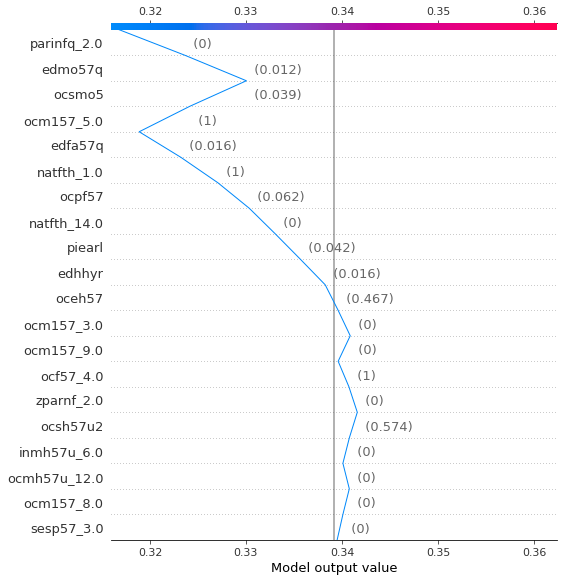

In [0]:
shap.initjs()
i = 10
shap.decision_plot(explainer.expected_value[1], shap_values[1][i], df_test.iloc[i,6:])

###Variable Importance and Global Interprebility

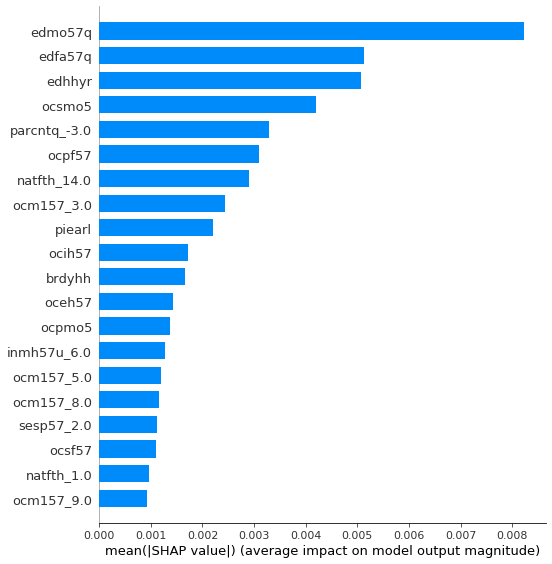

In [0]:
shap.summary_plot(shap_values[1], feature_names=df_train.columns[6:], plot_type='bar')

### PDP
We will show the shap PDP plots for the first 3 most important variables below. 

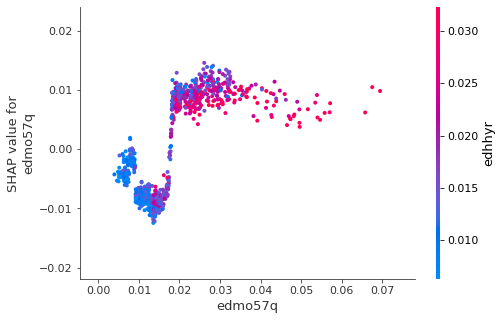

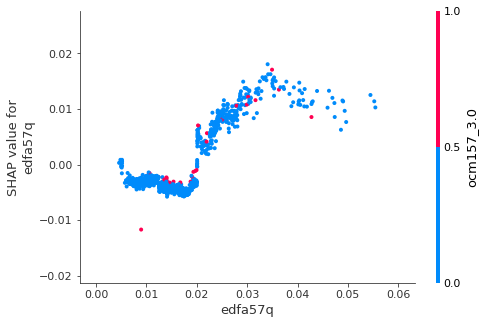

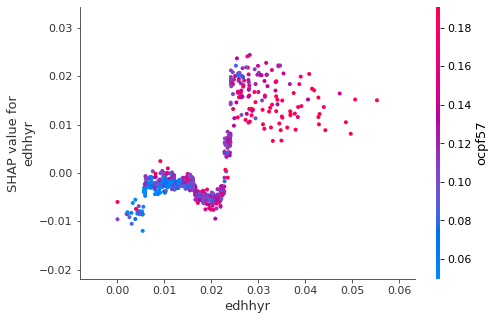

In [0]:
shap.dependence_plot('edmo57q', shap_values[1], df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('edfa57q', shap_values[1], df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('edhhyr', shap_values[1], df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])

##Results Analysis iv210rer

####Set up

In [0]:
n_explain = 1000
col = 'iv210rer'
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=2, seed=20190005)           
df_final = Resample(df_train, col)
X_train = df_final.iloc[:,6:]
y_train = df_final[col]
xgb_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_clf, df_test.iloc[0:n_explain,6:])

In [0]:
shap_values = explainer.shap_values(df_test.iloc[0:n_explain,6:])

 96%|=================== | 958/1000 [00:15<00:00]       

###Local interprebility

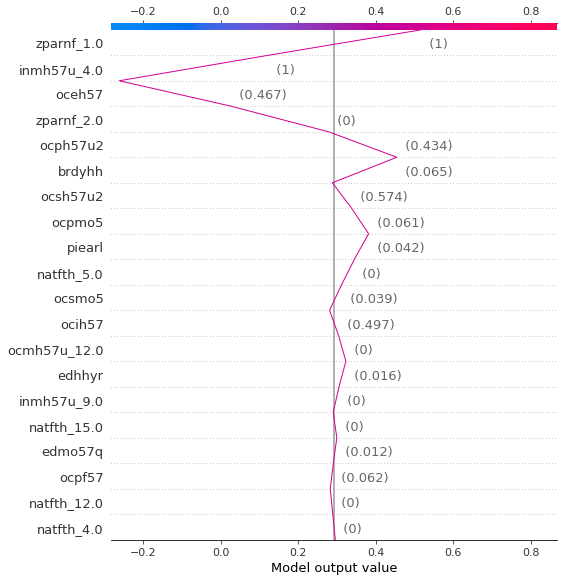

In [0]:
shap.initjs()
i = 10
shap.decision_plot(explainer.expected_value, shap_values[i], df_test.iloc[i,6:])

###Variable Importance and Global Interprebility

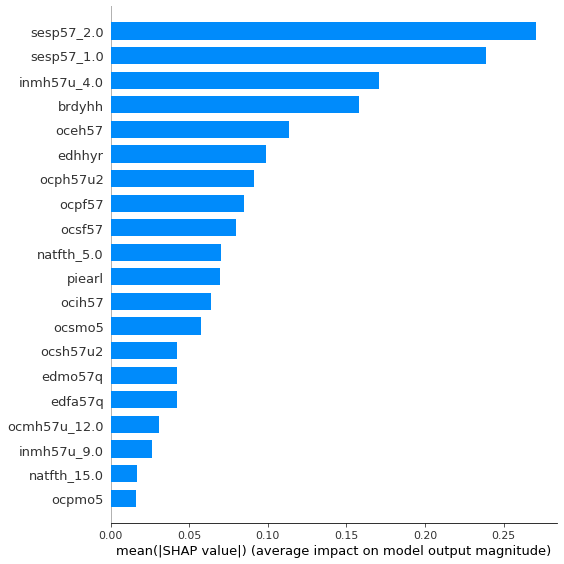

In [0]:
shap.summary_plot(shap_values, feature_names=df_train.columns[6:], plot_type='bar')

### PDP
We will show the shap PDP plots for the first 3 most important variables below. 

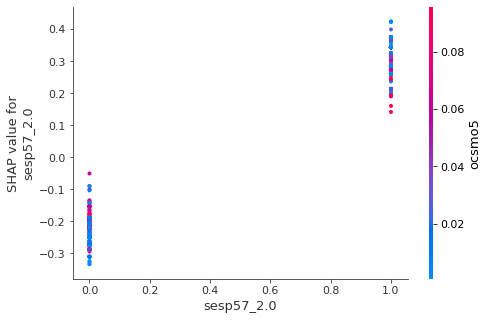

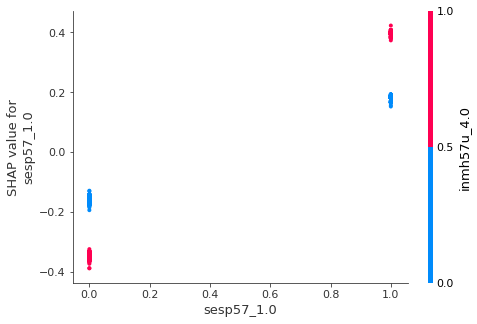

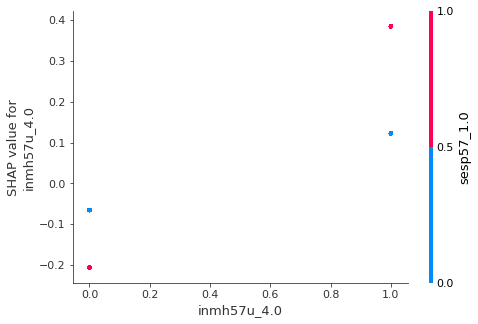

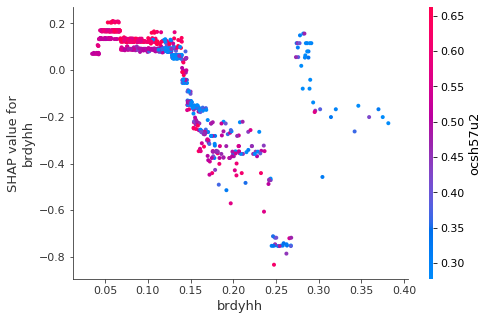

In [0]:
shap.dependence_plot('sesp57_2.0', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('sesp57_1.0', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('inmh57u_4.0', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('brdyhh', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])

##Results Analysis iv211rer

####Set up

In [0]:
n_explain = 1000
col = 'iv211rer'
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=2, seed=20190005)           
df_final = Resample(df_train, col)
X_train = df_final.iloc[:,6:]
y_train = df_final[col]
xgb_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_clf, df_test.iloc[0:n_explain,6:])

In [0]:
shap_values = explainer.shap_values(df_test.iloc[0:n_explain,6:])

 96%|=================== | 955/1000 [00:15<00:00]       

###Local interprebility

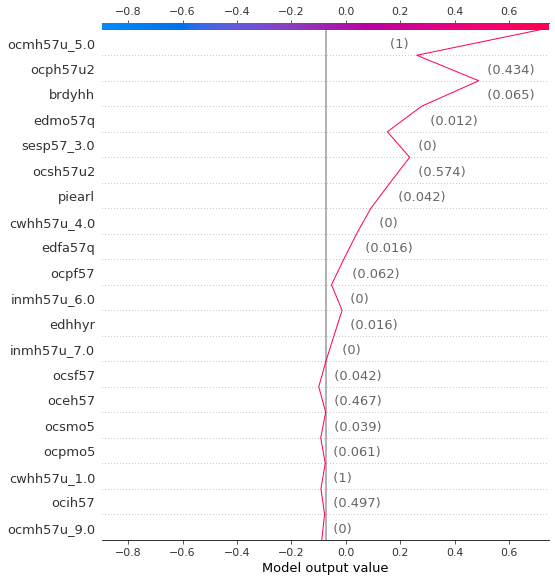

In [0]:
shap.initjs()
i = 10
shap.decision_plot(explainer.expected_value, shap_values[i], df_test.iloc[i,6:])

###Variable Importance and Global Interprebility

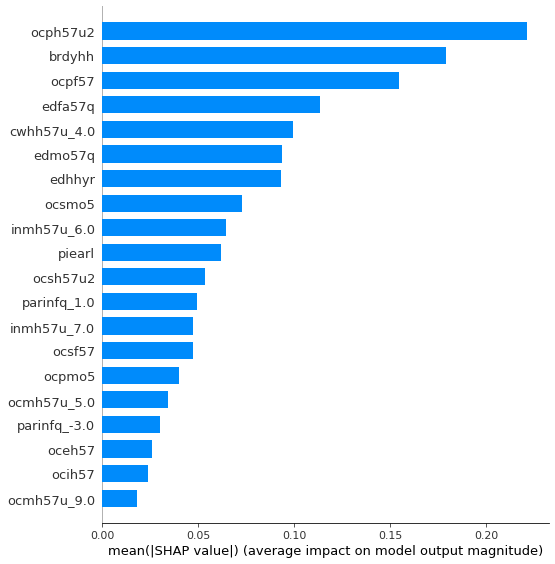

In [0]:
shap.summary_plot(shap_values, feature_names=df_train.columns[6:], plot_type='bar')

### PDP
We will show the shap PDP plots for the first 3 most important variables below. 

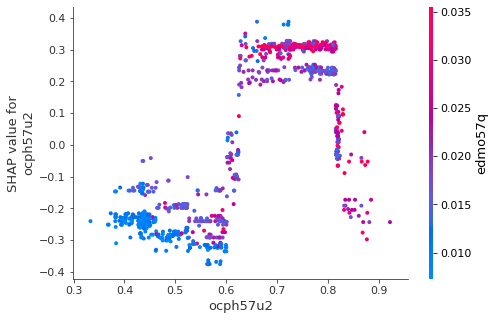

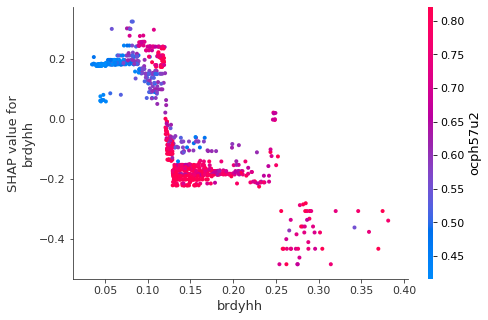

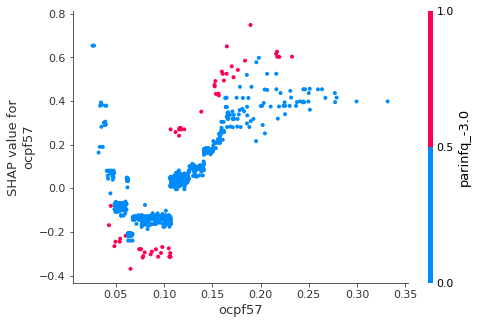

In [0]:
shap.dependence_plot('ocph57u2', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('brdyhh', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('ocpf57', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])

##Results Analysis iv212rer

####Set up

In [0]:
n_explain = 1000
col = 'iv212rer'
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=2, seed=20190005)           
df_final = Resample(df_train, col)
X_train = df_final.iloc[:,6:]
y_train = df_final[col]
xgb_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_clf, df_test.iloc[0:n_explain,6:])

In [0]:
shap_values = explainer.shap_values(df_test.iloc[0:n_explain,6:])

100%|===================| 999/1000 [00:16<00:00]       

###Local interprebility

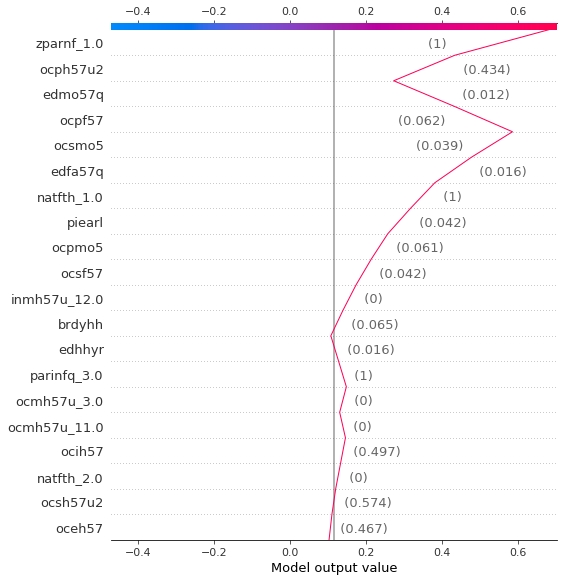

In [0]:
shap.initjs()
i = 10
shap.decision_plot(explainer.expected_value, shap_values[i], df_test.iloc[i,6:])

###Variable Importance and Global Interprebility

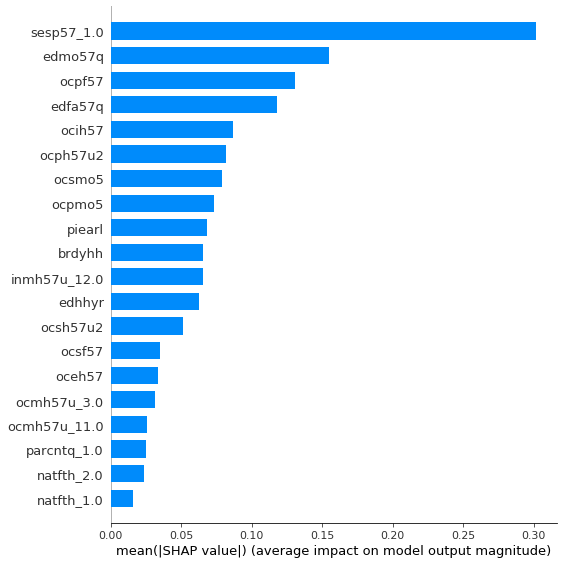

In [0]:
shap.summary_plot(shap_values, feature_names=df_train.columns[6:], plot_type='bar')

### PDP
We will show the shap PDP plots for the first 3 most important variables below. 

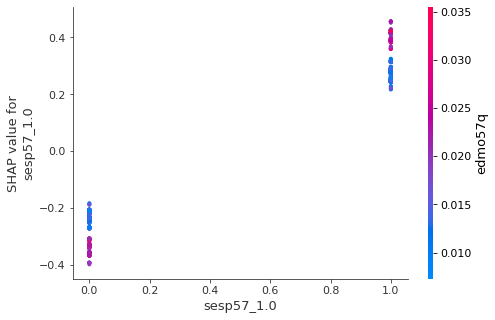

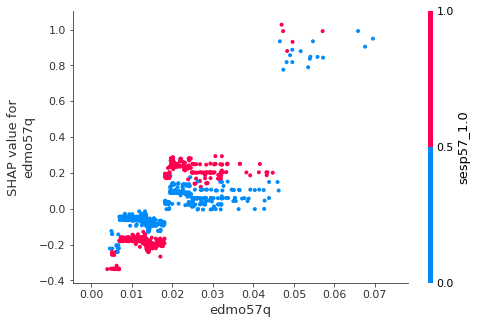

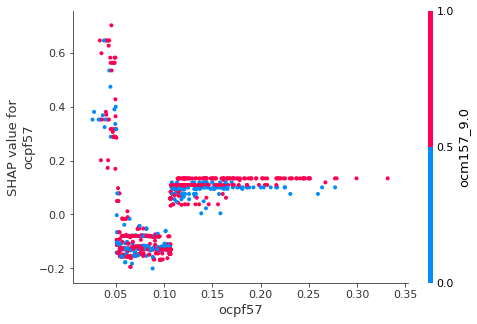

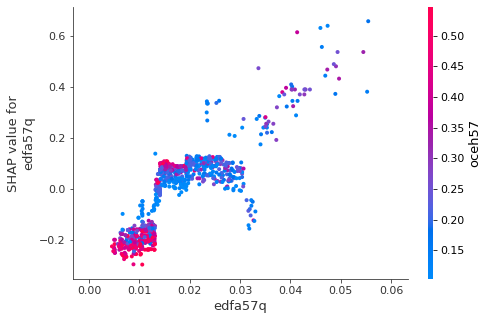

In [0]:
shap.dependence_plot('sesp57_1.0', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('edmo57q', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('ocpf57', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('edfa57q', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])

##Results Analysis iv213rer

####Set up

In [0]:
n_explain = 1000
col = 'iv213rer'
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=2, seed=20190005)           
df_final = Resample(df_train, col)
X_train = df_final.iloc[:,6:]
y_train = df_final[col]
xgb_clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_clf, df_test.iloc[0:n_explain,6:])

In [0]:
shap_values = explainer.shap_values(df_test.iloc[0:n_explain,6:])

 98%|===================| 985/1000 [00:16<00:00]       

###Local interprebility

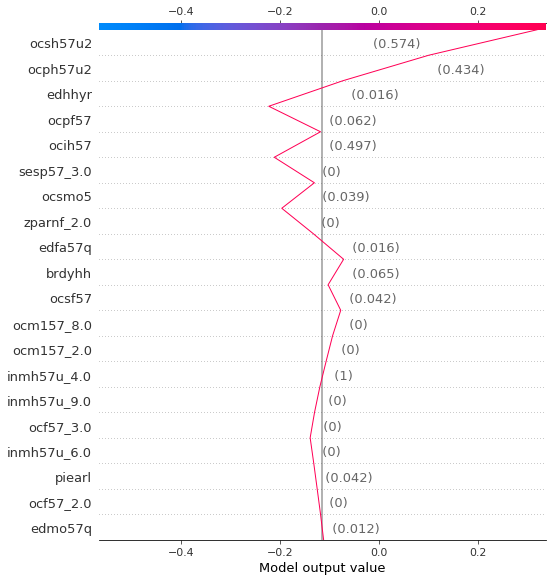

In [0]:
shap.initjs()
i = 10
shap.decision_plot(explainer.expected_value, shap_values[i], df_test.iloc[i,6:])

###Variable Importance and Global Interprebility

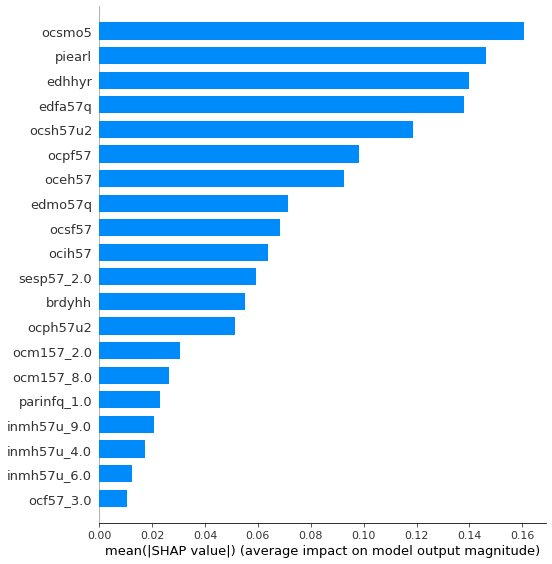

In [0]:
shap.summary_plot(shap_values, feature_names=df_train.columns[6:], plot_type='bar')

### PDP
We will show the shap PDP plots for the first 3 most important variables below. 

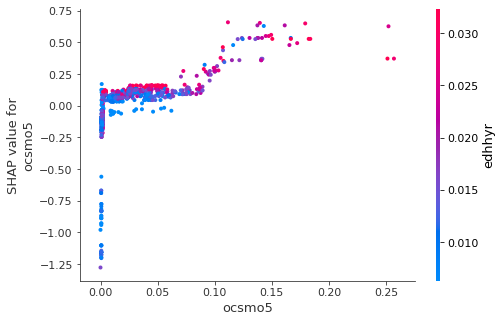

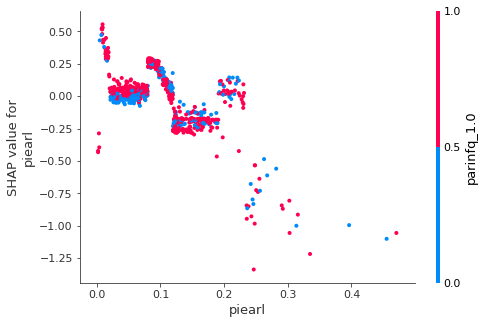

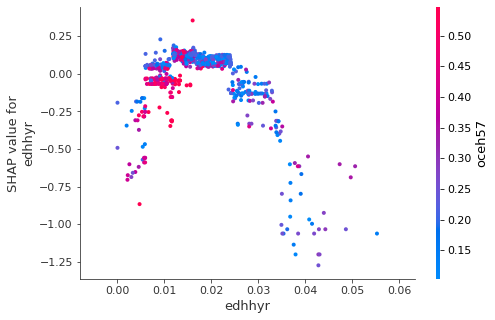

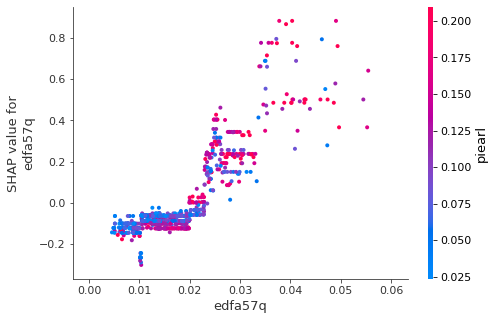

In [0]:
shap.dependence_plot('ocsmo5', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('piearl', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('edhhyr', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])
shap.dependence_plot('edfa57q', shap_values, df_test.iloc[:n_explain,6:].values, feature_names=df_train.columns[6:])